- 시작 하기 전에

이 코드는 python 3.10 버전 기준으로 돌아가는 코드입니다. 해당 버전에서 아래 라이브러리들을 전부 설치해주셔야 돌아갑니다

그리고 처음부터 전부 작동시키면 하루정도 걸려야 다 돌아가니 가급적 제가드린 데이터파일(중간 세이브 파일 개념)을 사용해주세요.

밑바닥부터 다 돌려보고 싶다면 dataguide에서 데이터 받아서 돌리시면 됩니다만 권장하진 않습니다.

In [27]:
import yfinance as yf
import pandas as pd

# 수집할 지표의 티커(symbol) 목록
tickers = {
    'KRW_USD_Exchange': 'KRW=X', # 원/달러 환율
    # 추가적인 지표를 여기에 추가
}

# 데이터프레임을 저장할 딕셔너리
data = {}

# 각 티커에 대해 데이터 다운로드
for name, ticker in tickers.items():
    # 데이터 다운로드
    df = yf.download(ticker, start='2007-9-30', end='2024-12-01', interval='1mo')
    # 월말 데이터로 리샘플링
    df = df.resample('M').last()
    # 필요한 열만 선택
    df = df[['Adj Close']]
    # 열 이름 변경
    df.columns = [name]
    # 딕셔너리에 저장
    data[name] = df

# 모든 데이터를 하나의 데이터프레임으로 병합
result = pd.concat(data.values(), axis=1)

# 결과 출력
result.to_csv('KRW_USD_Exchange.csv')        

[*********************100%***********************]  1 of 1 completed


In [53]:
import pandas as pd
import glob
from tqdm import tqdm
import os
import warnings
import gc
import numpy as np
import itertools
from tqdm import tqdm
import hotshot as hs
import networkx as nx  # networkx 임포트
from causalnex.structure.notears import from_pandas
from causalnex.network import BayesianNetwork
from econml.dr import DRLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import zscore

# 팩터 전략별로 필요한 데이터를 계산하여 monthly_merged_df에 추가합니다.

if 'monthly_merged_df' not in globals():
    monthly_merged_df = pd.read_csv(
        'data/merged_df_monthly_preprocessing.csv',
        header=[0, 1, 2, 3],
        index_col=0,
        parse_dates=True
    )

pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

# CSV 부르기 및 기본적인 전처리

In [3]:
# DataFrame을 저장할 리스트 생성
df_list = []

# 1. 'data' 폴더 내에 'KSIF'가 포함된 CSV 파일 목록 가져오기
file_list = glob.glob('data/*KSIF*.csv')

# 파일이 존재하는지 확인
if not file_list:
    print("패턴에 맞는 파일을 찾을 수 없습니다.")
elif os.path.exists('data/merged_df_monthly.csv'):
    print("이미 통합한 월별 데이터 파일이 존재합니다. 해당 CSV를 불러옵니다.")
    merged_df_backup = pd.read_csv(
        'data/merged_df_monthly.csv',
        header=[0, 1, 2, 3],
        index_col=0,  # 첫 번째 열을 인덱스로 사용
        parse_dates=True  # 인덱스를 datetime으로 파싱
    )
    print("월별 CSV를 불러왔습니다.")
elif os.path.exists('data/merged_data.csv'):
    print("이미 통합한 일별 데이터 파일이 존재합니다. 해당 CSV를 월별로 전환합니다.")
    merged_df_backup = pd.read_csv(
        'data/merged_data.csv',
        header=[0, 1, 2, 3],
        index_col=0,
        parse_dates=True
    )
    # 인덱스를 datetime으로 변환
    merged_df_backup.index = pd.to_datetime(merged_df_backup.index, errors='coerce')
    
    # 월별 리샘플링
    merged_df_backup = merged_df_backup.resample('M').last()
    
    # 월별 데이터 저장
    merged_df_backup.to_csv('data/merged_df_monthly.csv', encoding='utf-8-sig')
    
    print("월별 리샘플링된 데이터가 'merged_df_monthly.csv'로 저장되었습니다.")
    print("월별 CSV를 불러왔습니다.")
else:
    # tqdm을 사용하여 진행 상황 표시
    for file_path in tqdm(file_list, desc="파일 처리 중"):
        # 각 CSV 파일 읽기 (적절한 인코딩과 인덱스 설정)
        try:
            df = pd.read_csv(
                file_path,
                skiprows=8,
                header=[0, 1, 2, 3, 4, 5],
                index_col=0,  # 첫 번째 열을 인덱스로 사용
                encoding='cp949',
                parse_dates=True
            )
        except UnicodeDecodeError:
            # 'cp949' 인코딩이 안 될 경우 'euc-kr'로 시도
            df = pd.read_csv(
                file_path,
                skiprows=8,
                header=[0, 1, 2, 3, 4, 5],
                index_col=0,
                encoding='euc-kr',
                parse_dates=True
            )
        except Exception as e:
            print(f"파일 {file_path}를 로드하는 중 에러 발생: {e}")
            continue  # 에러 발생 시 다음 파일로 넘어감
        
        # 멀티인덱스 컬럼에 이름 지정
        df.columns.names = ['Symbol', 'Symbol Name', 'Kind', 'item', 'item Name', 'Frequency']
        
        # 인덱스 이름 지정 ('Date'로 설정)
        df.index.name = 'Date'
        
        # 인덱스를 datetime으로 변환
        df.index = pd.to_datetime(df.index, errors='coerce')
        
        # 'Kind', 'Frequency' 레벨 제거하여 필요한 컬럼만 남김
        df.columns = df.columns.droplevel(['Kind', 'Frequency'])
        
        # 리스트에 DataFrame 추가
        df_list.append(df)
    
    # 2. 모든 DataFrame을 수평적으로 병합
    print("DataFrame 병합 중...")
    merged_df_backup = pd.concat(df_list, axis=1)
    del df_list  # 리스트 메모리에서 삭제
    gc.collect()  # 가비지 컬렉션 실행
    
    # 월별 리샘플링
    print("월별 리샘플링 중...")
    merged_df_backup = merged_df_backup.resample('M').last()
    
    # 월별 데이터 저장
    merged_df_backup.to_csv('data/merged_df_monthly.csv', encoding='utf-8-sig')
    
    print("월별 리샘플링된 데이터가 'merged_df_monthly.csv'로 저장되었습니다.")
    
    # 필요에 따라 일별 데이터를 저장하려면 아래 주석을 해제하세요.
    # merged_df_backup.to_csv('data/merged_data.csv', encoding='utf-8-sig')
    # print("모든 CSV 파일을 병합하여 'merged_data.csv'로 저장했습니다.")

    # 메모리 관리
    del merged_df_backup
    gc.collect()

이미 통합한 월별 데이터 파일이 존재합니다. 해당 CSV를 불러옵니다.
월별 CSV를 불러왔습니다.


In [2]:
def check_dataframe_issues(df_list):
    """
    점검 함수: 데이터프레임 리스트에서 고유하지 않은 인덱스와 기준 인덱스 불일치 확인
    Args:
        df_list (list): pandas 데이터프레임들의 리스트
    Returns:
        dict: 문제를 가진 데이터프레임의 인덱스 (non_unique_index, mismatched_index)
    """
    # 결과 저장용 딕셔너리
    issues = {"non_unique_index": [], "mismatched_index": []}
    
    # 기준 인덱스는 첫 번째 데이터프레임의 인덱스로 설정
    base_index = df_list[0].index

    # 각 데이터프레임 점검
    for i, df in enumerate(df_list):
        # 1. 고유하지 않은 인덱스 확인
        if not df.index.is_unique:
            issues["non_unique_index"].append(i)
        
        # 2. 기준 인덱스와 불일치 확인
        if not base_index.equals(df.index):
            issues["mismatched_index"].append(i)

    return issues

# 점검 실행
check_dataframe_issues(df_list)#여기서 인덱스 2번이 뜨는 이유는 얘가 하루 더 있거등요 ㅇㅇ

IndexError: list index out of range

In [3]:
merged_df_backup.columns.get_level_values(3).unique()#우리 데이터 뭐있나 함 볼까?

Index(['수정주가(원)', 'PER(보통)(배)', 'PER(직전4분기)(배)', 'PER(보통,자사주차감)(배)',
       'BPS(발표기준기말주식수)(원)', 'BPS(자사주차감)(원)', '상장주식수(주)', '시가총액 (평균)(원)',
       '상장주식수 (보통)(주)', '매출총이익(원)', '총자산(원)', '유동자산(원)', '현금및현금성자산(원)',
       '유동부채(원)', '단기차입금(원)', '이연법인세부채(원)', '거래대금(원)', '관리종목지정사유', '기타포괄손익(원)',
       '베타 (M,3Yr)', '베타 (D,1Yr)', '보통주자본금(원)', '수익률(%)', '수익률 (1개월)(%)',
       '수정주가 (52주 최고)(원)', '유무형자산상각비(원)', '이익잉여금(원)', 'Unnamed: 3182_level_4',
       '이익잉여금(천원)'],
      dtype='object', name='item Name')

In [ ]:
import numpy as np

# 월별 데이터로 작업할 merged_df 생성
merged_df = merged_df_backup.copy()

# 1. "(원)"으로 끝나는 컬럼 처리
# 'item Name'이 '(원)'으로 끝나는 컬럼 선택
won_mask = merged_df.columns.get_level_values('item Name').str.endswith('(원)')

# 쉼표 제거 및 숫자 변환을 벡터화된 연산으로 수행
# 문자열 'None', 'nan', '', 'N/A' 등을 NaN으로 변환
merged_df.loc[:, won_mask] = (
    merged_df.loc[:, won_mask]
    .astype(str)  # 모든 데이터를 문자열로 변환
    .replace(',', '', regex=True)  # 쉼표 제거
    .replace(['', 'None', 'nan', 'NaN', 'N/A'], np.nan)  # 비정상적인 값들을 NaN으로 변환
    .apply(pd.to_numeric, errors='coerce')  # 숫자로 변환 (변환 불가 시 NaN)
)

print("'(원)' 컬럼의 문자열 변환 및 숫자 변환 완료")

# 2. '홀딩스', '지주', '스펙'으로 끝나는 종목 제거
pattern = ('홀딩스', '지주', '스펙', '스팩')
symbol_names = merged_df.columns.get_level_values('Symbol Name')
mask = symbol_names.str.endswith(pattern)
merged_df = merged_df.loc[:, ~mask]

# 3. '관리종목지정사유' 처리
# '관리종목지정사유'가 있는 종목 추출
management_mask = merged_df.columns.get_level_values('item Name') == '관리종목지정사유'
management_df = merged_df.loc[:, management_mask]

# 인덱스를 datetime 형태로 변환
merged_df.index = pd.to_datetime(merged_df.index, errors='coerce')

# 각 종목별로 처리
for symbol in management_df.columns.get_level_values('Symbol').unique():
    symbol_management = management_df.loc[:, management_df.columns.get_level_values('Symbol') == symbol]
    
    # NaN이 아닌 첫 번째 날짜 찾기
    dates_with_issue = symbol_management[symbol_management.notna().any(axis=1)].index
    
    if not dates_with_issue.empty:
        try:
            # 이슈 발생 날짜
            issue_date = dates_with_issue[0]
            
            # 해당 Symbol의 데이터를 처리
            symbol_mask = merged_df.columns.get_level_values('Symbol') == symbol
            price_mask = merged_df.columns.get_level_values('item Name') == '수정주가(원)'
            other_mask = symbol_mask & ~price_mask
            
            # 이슈 발생 월부터 이후 데이터에 대해 NaN으로 설정 (수정주가는 제외)
            merged_df.loc[merged_df.index >= issue_date, other_mask] = np.nan
            
        except Exception as e:
            print(f"Error processing symbol: {symbol}, issue_date: {issue_date}, Error: {e}")

print('관리종목 포트폴리오 정상화')

# 4. '거래대금(원)' 기반 종목 제거
trading_value_mask = merged_df.columns.get_level_values('item Name') == '거래대금(원)'
trading_value_df = merged_df.loc[:, trading_value_mask]

# 인덱스를 datetime으로 변환
trading_value_df.index = pd.to_datetime(trading_value_df.index)

# 2014년 이후 데이터 선택
trading_value_df = trading_value_df[trading_value_df.index >= '2014-01-31']

# 문자열을 숫자로 변환 (오류 발생 시 NaN 처리)
trading_value_df = trading_value_df.apply(pd.to_numeric, errors='coerce')

# 거래대금이 4천만원 이하인 경우 True, NaN은 False로 처리
low_trading_value = (trading_value_df <= 40000000).fillna(False)

# 각 Symbol마다 거래대금이 4천만원 이하인 달이 하나라도 있는지 확인
symbols_to_remove = low_trading_value.any(axis=0)
symbols_to_remove = symbols_to_remove[symbols_to_remove].index.get_level_values('Symbol').unique().tolist()

# 해당 Symbol 제거
symbol_mask = merged_df.columns.get_level_values('Symbol').isin(symbols_to_remove)
merged_df = merged_df.loc[:, ~symbol_mask]

print('market impact 조정 완료')

# 5. 수정주가 기반 1개월 수익률 계산
# 인덱스를 datetime으로 변환
merged_df.index = pd.to_datetime(merged_df.index)

# '수정주가(원)' 데이터 추출
price_mask = merged_df.columns.get_level_values('item Name') == '수정주가(원)'
price_df = merged_df.loc[:, price_mask]

# 월별 수익률 계산
returns_df = price_df.pct_change()

# 'item Name'을 '1개월 수익률(계산)'으로 변경
returns_df.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, item, '1개월 수익률(계산)') for symbol, symbol_name, item in zip(
        returns_df.columns.get_level_values('Symbol'),
        returns_df.columns.get_level_values('Symbol Name'),
        returns_df.columns.get_level_values('item')
    )],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

# 수익률 데이터를 merged_df에 추가
merged_df = pd.concat([merged_df, returns_df], axis=1)

print('1개월 수익률 계산 완료')

# 6. 결측치를 직전 값으로 대체
merged_df = merged_df.fillna(method='ffill')

print("전처리 완료")

In [ ]:
merged_df.to_csv('data/merged_df_monthly_preprocessing.csv', encoding='utf-8-sig')

In [22]:
merged_df_backup.dtypes

Symbol   Symbol Name  item        item Name       
A000660  SK하이닉스       S410000700  수정주가(원)               int64
                      6000701101  PER(보통)(배)          float64
                      6000701007  PER(직전4분기)(배)       float64
                      6000701006  PER(보통,자사주차감)(배)    float64
A373220  LG에너지솔루션     S410000700  수정주가(원)             float64
                                                       ...   
A900030  연합과기         S410000700  1개월 수익률(계산)         float64
A900060  중국식품포장       S410000700  1개월 수익률(계산)         float64
A900150  성융광전투자       S410000700  1개월 수익률(계산)         float64
A950030  네프로아이티       S410000700  1개월 수익률(계산)         float64
A950070  중국고섬         S410000700  1개월 수익률(계산)         float64
Length: 58059, dtype: object

# 팩터값 계산

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# 팩터 전략별로 필요한 데이터를 계산하여 monthly_merged_df에 추가합니다.

if 'monthly_merged_df' not in globals():
    monthly_merged_df = pd.read_csv(
        'data/merged_df_monthly_preprocessing.csv',
        header=[0, 1, 2, 3],
        index_col=0,
        parse_dates=True
    )

In [12]:
# ===== 팩터 전략 1: High P/E Ratio =====
# 상위 20% 종목에 롱 포지션, 하위 20% 종목에 숏 포지션을 취하는 전략

# 'PER(직전4분기)(배)' 데이터 추출
per_mask = monthly_merged_df.columns.get_level_values('item Name') == 'PER(보통,자사주차감)(배)'
per_df = monthly_merged_df.loc[:, per_mask]
per_df.columns = per_df.columns.droplevel(['item', 'item Name'])

# 결측치 처리 전에 per_df의 데이터를 float 타입으로 변환
per_df = per_df.apply(pd.to_numeric, errors='coerce')

# 결측치 처리
per_df = per_df.replace(0, np.nan)
per_df = per_df.replace(np.inf, np.nan)
per_df = per_df.fillna(method='ffill')

# 전체 종목에 대해 z-score 계산
per_zscore = -per_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# 팩터 값 저장
per_zscore.to_csv('factor_high_pe_ratio.csv', encoding='utf-8-sig')
print("'factor_high_pe_ratio.csv' 파일이 저장되었습니다.")

# 산업 분류 데이터 불러오기
try:
    industry_df = pd.read_csv(
        'data/industry.csv',
        header=[0, 1, 2, 3],
        index_col=0,
        parse_dates=True
    )
except UnicodeDecodeError:
    industry_df = pd.read_csv(
        'data/industry.csv',
        header=[0, 1, 2, 3],
        index_col=0,  # 첫 번째 열을 인덱스로 사용
        encoding='cp949',
        parse_dates=True  # 인덱스를 datetime으로 파싱
    )
    
# 멀티인덱스 설정
industry_df.columns.names = ['Symbol', 'Symbol Name', 'item', 'item Name']
industry_df.index.name = 'Date'

# '한국표준산업분류10차(대분류)', '한국표준산업분류10차(중분류)' 데이터 추출
industry_large_mask = industry_df.columns.get_level_values('item Name') == '한국표준산업분류11차(대분류)'
industry_medium_mask = industry_df.columns.get_level_values('item Name') == '한국표준산업분류11차(중분류)'

industry_large_df = industry_df.loc[:, industry_large_mask]
industry_large_df.columns = industry_large_df.columns.droplevel(['item', 'item Name'])
industry_medium_df = industry_df.loc[:, industry_medium_mask]
industry_medium_df.columns = industry_medium_df.columns.droplevel(['item', 'item Name'])

# PER 데이터와 산업 분류 데이터의 인덱스 및 컬럼 정렬
per_df, industry_large_df = per_df.align(industry_large_df, join='inner', axis=1)
per_df, industry_medium_df = per_df.align(industry_medium_df, join='inner', axis=1)

# 디버깅 출력을 위한 함수
def debug_print(message, df=None):
    print(message)
    if df is not None:
        print(df.head())
        print(df.shape)
        print("-" * 50)

# 산업별로 z-score 계산
def industry_zscore(per_series, industry_series):
    df = pd.DataFrame({'PER': per_series, 'Industry': industry_series})
    # NaN 값이 있는 행 제거
    df = df.dropna()
    # 산업별 그룹화 및 z-score 계산
    grouped = df.groupby('Industry')
    z_scores = grouped['PER'].transform(lambda x: -(x - x.mean()) / x.std() if x.std() != 0 else 0)
    return z_scores

# 대분류 산업별 z-score
per_zscore_large = per_df.copy()
print(per_zscore_large.shape)
for date in per_zscore_large.index:
    per_zscore_large.loc[date] = industry_zscore(per_df.loc[date], industry_large_df.loc[date])
    # 디버깅 출력
    # debug_print(f"[Large Industry] Date: {date}", per_zscore_large.loc[[date]])

# 멀티레벨 컬럼 구조 설정
per_zscore_large.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'PER_zscore_large', 'PER_zscore_large') for symbol, symbol_name in per_zscore_large.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

# 팩터 값 저장
per_zscore_large.to_csv('factor_high_pe_ratio_large_industry.csv', encoding='utf-8-sig')
print("'factor_high_pe_ratio_large_industry.csv' 파일이 저장되었습니다.")

# 중분류 산업별 z-score
per_zscore_medium = per_df.copy()
for date in per_zscore_medium.index:
    per_zscore_medium.loc[date] = industry_zscore(per_df.loc[date], industry_medium_df.loc[date])
    # 디버깅 출력
    # debug_print(f"[Medium Industry] Date: {date}", per_zscore_medium.loc[[date]])

# 멀티레벨 컬럼 구조 설정
per_zscore_medium.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'PER_large', 'PER_large') for symbol, symbol_name in per_zscore_medium.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)
# 팩터 값 저장
per_zscore_medium.to_csv('factor_high_pe_ratio_medium_industry.csv', encoding='utf-8-sig')
print("'factor_high_pe_ratio_medium_industry.csv' 파일이 저장되었습니다.")

# 팩터 값 저장
per_zscore.to_csv('factor_high_pe_ratio.csv', encoding='utf-8-sig')

'factor_high_pe_ratio.csv' 파일이 저장되었습니다.
(206, 2052)
'factor_high_pe_ratio_large_industry.csv' 파일이 저장되었습니다.
'factor_high_pe_ratio_medium_industry.csv' 파일이 저장되었습니다.


In [7]:
# ===== 팩터 전략 2: HML (Kang, 2013) =====
# Book-to-Market Ratio 계산 (BPS / 주가)

# 'BPS(자사주차감)(원)' 데이터 추출
bps_mask = monthly_merged_df.columns.get_level_values('item Name') == 'BPS(자사주차감)(원)'
bps_df = monthly_merged_df.loc[:, bps_mask]

# '수정주가(원)' 데이터 추출
price_mask = monthly_merged_df.columns.get_level_values('item Name') == '수정주가(원)'
price_df = monthly_merged_df.loc[:, price_mask]

# 컬럼 레벨 중 'item'과 'item Name'을 제거하여 컬럼 정렬
bps_df.columns = bps_df.columns.droplevel(['item', 'item Name'])
price_df.columns = price_df.columns.droplevel(['item', 'item Name'])

# 인덱스 및 컬럼 정렬
bps_df, price_df = bps_df.align(price_df, join='inner', axis=0)
bps_df, price_df = bps_df.align(price_df, join='inner', axis=1)

# 계산 전에 데이터 타입 변환
bps_df = bps_df.apply(pd.to_numeric, errors='coerce')
price_df = price_df.apply(pd.to_numeric, errors='coerce')

# Book-to-Market Ratio 계산
bm_ratio_df = bps_df / price_df

# 결측치 처리
bm_ratio_df = bm_ratio_df.replace([np.inf, -np.inf], np.nan)
bm_ratio_df = bm_ratio_df.fillna(method='ffill')

# 멀티레벨 컬럼 구조 재설정
bm_ratio_df.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'BM Ratio', 'BM Ratio') for symbol, symbol_name in bm_ratio_df.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

# 팩터 값 저장
bm_ratio_df.to_csv('factor_hml.csv', encoding='utf-8-sig')
print("'factor_hml.csv' 파일이 저장되었습니다.")

'factor_hml.csv' 파일이 저장되었습니다.


In [8]:
# ===== 팩터 전략 5: Momentum 전략 =====
# 지난 12-1개월 수익률 계산 (직전 1개월은 제외)

# '수정주가(원)' 데이터 추출
price_mask = monthly_merged_df.columns.get_level_values('item Name') == '수정주가(원)'
price_df = monthly_merged_df.loc[:, price_mask]
price_df.columns = price_df.columns.droplevel(['item', 'item Name'])

# 데이터 타입 변환
price_df = price_df.apply(pd.to_numeric, errors='coerce')

# 인덱스 및 컬럼 정렬
price_df = price_df.sort_index()

# 결측치 처리
price_df = price_df.fillna(method='ffill')

# 12개월 전 가격과 1개월 전 가격 추출
price_12m_ago = price_df.shift(12)
price_1m_ago = price_df.shift(1)

# 모멘텀 계산
momentum_df = (price_1m_ago - price_12m_ago) / price_12m_ago

# 결측치 처리
momentum_df = momentum_df.replace([np.inf, -np.inf], np.nan)
momentum_df = momentum_df.fillna(method='ffill')

# 전체 종목에 대해 z-score 계산
momentum_zscore = momentum_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# 산업 분류 데이터 불러오기 (이미 불러온 industry_df 사용)
# '한국표준산업분류11차(대분류)', '한국표준산업분류11차(중분류)' 데이터 추출
industry_large_mask = industry_df.columns.get_level_values('item Name') == '한국표준산업분류11차(대분류)'
industry_medium_mask = industry_df.columns.get_level_values('item Name') == '한국표준산업분류11차(중분류)'

industry_large_df = industry_df.loc[:, industry_large_mask]
industry_large_df.columns = industry_large_df.columns.droplevel(['item', 'item Name'])
industry_medium_df = industry_df.loc[:, industry_medium_mask]
industry_medium_df.columns = industry_medium_df.columns.droplevel(['item', 'item Name'])

# 산업별로 z-score 계산
def industry_zscore(per_series, industry_series):
    df = pd.DataFrame({'PER': per_series, 'Industry': industry_series})
    # NaN 값이 있는 행 제거
    df = df.dropna()
    # 산업별 그룹화 및 z-score 계산
    grouped = df.groupby('Industry')
    z_scores = grouped['PER'].transform(lambda x: -(x - x.mean()) / x.std() if x.std() != 0 else 0)
    return z_scores


# 대분류 산업별 z-score
momentum_zscore_large = momentum_df.copy()
for date in momentum_zscore_large.index:
    momentum_zscore_large.loc[date] = industry_zscore(momentum_df.loc[date], industry_large_df.loc[date])

# 중분류 산업별 z-score
momentum_zscore_medium = momentum_df.copy()
for date in momentum_zscore_medium.index:
    momentum_zscore_medium.loc[date] = industry_zscore(momentum_df.loc[date], industry_medium_df.loc[date])

# 멀티레벨 컬럼 구조 설정
# 원래의 컬럼 정보를 사용하여 멀티인덱스 생성
momentum_df.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'Momentum', 'Momentum') for symbol, symbol_name in momentum_df.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

momentum_zscore.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'Momentum_zscore', 'Momentum_zscore') for symbol, symbol_name in momentum_zscore.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

momentum_zscore_large.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'Momentum_large', 'Momentum_large') for symbol, symbol_name in momentum_zscore_large.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

momentum_zscore_medium.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'Momentum_medium', 'Momentum_medium') for symbol, symbol_name in momentum_zscore_medium.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

# 팩터 값 저장
momentum_df.to_csv('factor_momentum.csv', encoding='utf-8-sig')
momentum_zscore.to_csv('factor_momentum_zscore.csv', encoding='utf-8-sig')
momentum_zscore_large.to_csv('factor_momentum_large_industry.csv', encoding='utf-8-sig')
momentum_zscore_medium.to_csv('factor_momentum_medium_industry.csv', encoding='utf-8-sig')

print("'factor_momentum.csv', 'factor_momentum_zscore.csv', 'factor_momentum_large_industry.csv', 'factor_momentum_medium_industry.csv' 파일이 저장되었습니다.")

'factor_momentum.csv', 'factor_momentum_zscore.csv', 'factor_momentum_large_industry.csv', 'factor_momentum_medium_industry.csv' 파일이 저장되었습니다.


In [9]:
# ===== 팩터 전략 6: Retained Earnings and Market-to-Book =====
# 이익잉여금(원) / 시가총액 계산

# '이익잉여금(원)' 데이터 추출
retained_earnings_mask = monthly_merged_df.columns.get_level_values('item Name') == '이익잉여금(원)'
retained_earnings_df = monthly_merged_df.loc[:, retained_earnings_mask]

# '시가총액 (평균)(원)' 데이터 추출
market_cap_mask = monthly_merged_df.columns.get_level_values('item Name') == '시가총액 (평균)(원)'
market_cap_df = monthly_merged_df.loc[:, market_cap_mask]

# 컬럼 레벨 중 'item'과 'item Name'을 제거하여 컬럼 정렬
retained_earnings_df.columns = retained_earnings_df.columns.droplevel(['item', 'item Name'])
market_cap_df.columns = market_cap_df.columns.droplevel(['item', 'item Name'])

# 인덱스 및 컬럼 정렬
retained_earnings_df, market_cap_df = retained_earnings_df.align(market_cap_df, join='inner', axis=0)
retained_earnings_df, market_cap_df = retained_earnings_df.align(market_cap_df, join='inner', axis=1)

# 데이터 타입 변환
retained_earnings_df = retained_earnings_df.apply(pd.to_numeric, errors='coerce')
market_cap_df = market_cap_df.apply(pd.to_numeric, errors='coerce')

# 이익잉여금 / 시가총액 계산
re_mc_ratio_df = retained_earnings_df / market_cap_df

# 결측치 처리
re_mc_ratio_df = re_mc_ratio_df.replace([np.inf, -np.inf], np.nan)
re_mc_ratio_df = re_mc_ratio_df.fillna(method='ffill')

# 멀티레벨 컬럼 구조 재설정
re_mc_ratio_df.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'RE/MC Ratio', 'RE/MC Ratio') for symbol, symbol_name in re_mc_ratio_df.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

# 팩터 값 저장
re_mc_ratio_df.to_csv('factor_retained_earnings.csv', encoding='utf-8-sig')
print("'factor_retained_earnings.csv' 파일이 저장되었습니다.")

'factor_retained_earnings.csv' 파일이 저장되었습니다.


In [10]:
# ===== 팩터 전략 10: Betting Against Beta =====
# 베타를 직접 계산하여 역수를 팩터 값으로 사용

import pandas as pd
import numpy as np
from tqdm import tqdm

# 1. 전처리된 월별 데이터에서 종목 리스트와 기간 추출
symbols = monthly_merged_df.columns.get_level_values('Symbol').unique()
dates = monthly_merged_df.index.unique()

# 각 종목별로 시작 날짜 추출
symbol_start_dates = {}
for symbol in symbols:
    # 해당 종목의 컬럼 선택
    symbol_cols = monthly_merged_df.loc[:, monthly_merged_df.columns.get_level_values('Symbol') == symbol]
    # 해당 종목의 데이터가 있는 날짜 추출
    symbol_data = symbol_cols.dropna(how='all')
    # 데이터가 있는 경우
    if not symbol_data.empty:
        start_date = symbol_data.index.min()
        # 시작 날짜에서 30일을 뺌
        adjusted_start_date = start_date - pd.Timedelta(days=30)
        # daily_df의 시작 날짜와 비교하여 실제 시작 날짜 결정
        symbol_start_dates[symbol] = adjusted_start_date
    else:
        # 데이터가 없는 경우 최소 날짜 설정
        symbol_start_dates[symbol] = pd.to_datetime('2000-01-01')  # 필요에 따라 최소 날짜 설정

print(f"전처리된 종목 수: {len(symbols)}")

# 2. 일별 데이터 로드 (data/KSIF_1.csv 파일)
file_path = 'data/KSIF_1.csv'

try:
    daily_df = pd.read_csv(
        file_path,
        skiprows=8,
        header=[0, 1, 2, 3, 4, 5],
        index_col=0,
        encoding='cp949',
        parse_dates=True
    )
except UnicodeDecodeError:
    daily_df = pd.read_csv(
        file_path,
        skiprows=8,
        header=[0, 1, 2, 3, 4, 5],
        index_col=0,
        encoding='euc-kr',
        parse_dates=True
    )
except Exception as e:
    print(f"파일 {file_path}를 로드하는 중 에러 발생: {e}")
    raise e  # 에러 발생 시 종료

# 멀티인덱스 컬럼 이름 지정
daily_df.columns.names = ['Symbol', 'Symbol Name', 'Kind', 'item', 'item Name', 'Frequency']
daily_df.index.name = 'Date'

# 'Kind', 'Frequency' 레벨 제거
daily_df.columns = daily_df.columns.droplevel(['Kind', 'Frequency'])

# 필요한 종목(Symbol)만 선택
symbol_mask = daily_df.columns.get_level_values('Symbol').isin(symbols)
daily_df = daily_df.loc[:, symbol_mask]

print(f"필터링된 종목 수: {len(daily_df.columns.get_level_values('Symbol').unique())}")

# '수정주가(원)' 데이터 추출
price_mask = daily_df.columns.get_level_values('item Name') == '수정주가(원)'
daily_price_df = daily_df.loc[:, price_mask]
daily_price_df.columns = daily_price_df.columns.droplevel(['item', 'item Name'])

# 데이터 정제: 쉼표 제거 및 숫자 변환
daily_price_df = (
    daily_price_df
    .astype(str)  # 모든 데이터를 문자열로 변환
    .replace(',', '', regex=True)  # 쉼표 제거
    .replace(['', 'None', 'nan', 'NaN', 'N/A', ''], np.nan)  # 비정상적인 값들을 NaN으로 변환
    .apply(pd.to_numeric, errors='coerce')  # 숫자로 변환 (변환 불가 시 NaN)
)

# 데이터 타입 확인
print("일별 가격 데이터 타입 확인:")
print(daily_price_df.dtypes.unique())

# 종목별 일별 수익률 계산
daily_returns_dict = {}
for symbol in symbols:
    if symbol in daily_price_df.columns:
        symbol_price = daily_price_df[symbol]
        if not symbol_price.empty:
            # 해당 종목의 시작 날짜 계산
            start_date = symbol_start_dates[symbol]
            # 시작 날짜부터 데이터 선택
            symbol_price = symbol_price.loc[start_date:]
            # 수익률 계산
            symbol_returns = symbol_price.pct_change().dropna()
            daily_returns_dict[symbol] = symbol_returns
        else:
            # 해당 종목의 데이터가 없는 경우
            daily_returns_dict[symbol] = pd.Series(dtype=float)
    else:
        daily_returns_dict[symbol] = pd.Series(dtype=float)

print(f"일별 수익률 계산 완료. 종목 수: {len(daily_returns_dict)}")

# 시장 수익률 계산 (종가지수(포인트) 기반)
try:
    market_df = pd.read_csv(
        'data/kor_market.csv',
        skiprows=8,
        header=[0, 1, 2, 3, 4, 5],
        index_col=0,
        encoding='cp949',
        parse_dates=True
    )
except UnicodeDecodeError:
    market_df = pd.read_csv(
        'data/kor_market.csv',
        skiprows=8,
        header=[0, 1, 2, 3, 4, 5],
        index_col=0,
        encoding='euc-kr',
        parse_dates=True
    )

# 멀티인덱스 컬럼 이름 지정
market_df.columns.names = ['Symbol', 'Symbol Name', 'Kind', 'item', 'item Name', 'Frequency']
market_df.index.name = 'Date'

# 'Kind', 'Frequency' 레벨 제거
market_df.columns = market_df.columns.droplevel(['Kind', 'Frequency'])

# '종가지수(포인트)' 데이터 추출
index_mask = market_df.columns.get_level_values('item Name') == '종가지수(포인트)'
index_df = market_df.loc[:, index_mask]

# '코스피'와 '코스닥' 지수만 선택
symbol_names = index_df.columns.get_level_values('Symbol Name')
kospi_kosdaq_mask = (symbol_names == '코스피') | (symbol_names == '코스닥')
kospi_kosdaq_indices = index_df.loc[:, kospi_kosdaq_mask]
kospi_kosdaq_indices.columns = kospi_kosdaq_indices.columns.droplevel(['item', 'item Name'])

# 데이터 정제: 쉼표 제거 및 숫자 변환
kospi_kosdaq_indices = (
    kospi_kosdaq_indices
    .astype(str)
    .replace(',', '', regex=True)
    .replace(['', 'None', 'nan', 'NaN', 'N/A', ''], np.nan)
    .apply(pd.to_numeric, errors='coerce')
)

# 코스피와 코스닥 지수의 일별 수익률 계산
market_returns = kospi_kosdaq_indices.mean(axis=1).pct_change().dropna()

# 시장 수익률 데이터 기간 확인
print(f"시장 수익률 데이터 기간: {market_returns.index.min()} ~ {market_returns.index.max()}")

# 3. 베타 계산 함수 정의 및 계산
def calculate_beta(stock_returns, market_returns, window=365):
    # 결측치 제거
    combined = pd.concat([stock_returns, market_returns], axis=1).dropna()
    if len(combined) < 30:
        return np.nan
    else:
        stock_ret = combined.iloc[:, 0]
        market_ret = combined.iloc[:, 1]
        cov = stock_ret.cov(market_ret)
        var = market_ret.var()
        beta = cov / var if var != 0 else np.nan
        return beta

# 베타 값을 저장할 데이터프레임 생성
beta_df = pd.DataFrame(index=dates, columns=symbols)

for date in tqdm(dates, desc='베타 계산 중'):
    for symbol in symbols:
        # 해당 종목의 일별 수익률 시리즈
        stock_returns = daily_returns_dict[symbol]
        # 해당 날짜까지의 데이터 사용
        stock_returns = stock_returns[stock_returns.index <= date]
        market_returns_up_to_date = market_returns[market_returns.index <= date]
        # 최근 window 기간의 데이터 추출
        stock_returns = stock_returns.iloc[-365:]
        market_returns_up_to_date = market_returns_up_to_date.iloc[-365:]
        # 베타 계산
        beta = calculate_beta(stock_returns, market_returns_up_to_date)
        beta_df.at[date, symbol] = beta

# 베타의 역수를 팩터 값으로 사용
inv_beta_df = (1 / beta_df.astype(float)).replace([np.inf, -np.inf], np.nan)

# 멀티레벨 컬럼 구조 설정
inv_beta_df.columns = pd.MultiIndex.from_tuples(
    [(symbol, monthly_merged_df.columns.get_level_values('Symbol Name')[monthly_merged_df.columns.get_level_values('Symbol') == symbol][0], 'Inverse Beta', 'Inverse Beta') for symbol in inv_beta_df.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

inv_beta_df.index.name = 'Date'

# 팩터 값 저장
inv_beta_df.to_csv('factor_betting_against_beta.csv', encoding='utf-8-sig')

print("'factor_betting_against_beta.csv' 파일이 저장되었습니다.")

전처리된 종목 수: 2053
필터링된 종목 수: 2052
일별 가격 데이터 타입 확인:
[dtype('int64') dtype('float64')]
일별 수익률 계산 완료. 종목 수: 2053
시장 수익률 데이터 기간: 2007-10-21 00:00:00 ~ 2024-11-20 00:00:00


베타 계산 중: 100%|██████████████████████████████████████████████████████████████████| 206/206 [09:47<00:00,  2.85s/it]


'factor_betting_against_beta.csv' 파일이 저장되었습니다.


In [5]:
#계산한 팩터값에 결측치 확인
import pandas as pd

# ===== 팩터 값 CSV 확인 및 결측치 분석 =====

# 저장된 팩터 값 CSV 파일 목록
factor_files = [
    'factor_high_pe_ratio.csv',
    'factor_high_pe_ratio_large_industry.csv',
    'factor_high_pe_ratio_medium_industry.csv',
    'factor_hml.csv',
    'factor_momentum.csv',
    'factor_retained_earnings.csv',
    'factor_betting_against_beta.csv'
]

# 결과를 저장할 리스트
missing_data_summary = []

for file in factor_files:
    print(f"Processing file: {file}")
    try:
        # CSV 파일 로드
        factor_df = pd.read_csv(file, 
        header=[0, 1, 2, 3],
        index_col=0,
        parse_dates=True
        )

        # 멀티인덱스 설정
        factor_df.columns.names = ['Symbol', 'Symbol Name', 'item', 'item Name']
        factor_df.index.name = 'Date'
        
        print(f"  Loaded successfully. Shape: {factor_df.shape}")
        
        # 2008년 이후 데이터만 필터링
        factor_df = factor_df.loc[factor_df.index >= '2008-01-01']
        
        # 결측치 분석
        missing_summary = factor_df.isna().sum(axis=1)  # 각 날짜별 결측치 수
        total_columns = factor_df.shape[1]  # 전체 컬럼 수
        
        # 가장 결측치가 많은 날짜와 해당 날짜의 결측치 비율
        max_missing_date = missing_summary.idxmax()
        max_missing_count = missing_summary.max()
        max_missing_ratio = (max_missing_count / total_columns) * 100  # 결측치 비율
        
        # 결측치 요약 추가
        missing_data_summary.append({
            'Factor File': file,
            'Max Missing Date': max_missing_date,
            'Max Missing Count': max_missing_count,
            'Total Columns': total_columns,
            'Max Missing Ratio (%)': max_missing_ratio
        })
        
        print(f"  Max Missing Date: {max_missing_date}")
        print(f"  Max Missing Count: {max_missing_count}")
        print(f"  Total Columns: {total_columns}")
        print(f"  Max Missing Ratio (%): {max_missing_ratio:.2f}%")
        
    except Exception as e:
        print(f"  Error processing file {file}: {e}")

# 결측치 분석 결과 DataFrame 생성
missing_summary_df = pd.DataFrame(missing_data_summary)

# 결측치 분석 결과 출력
print("\n===== Missing Data Summary =====")
print(missing_summary_df)

# 결측치 분석 결과 저장
missing_summary_df.to_csv('factor_missing_data_summary.csv', index=False, encoding='utf-8-sig')
print("\n결측치 분석 결과가 'factor_missing_data_summary.csv' 파일로 저장되었습니다.")

Processing file: factor_high_pe_ratio.csv
  Loaded successfully. Shape: (206, 2067)
  Max Missing Date: 2008-01-31 00:00:00
  Max Missing Count: 1544
  Total Columns: 2067
  Max Missing Ratio (%): 74.70%
Processing file: factor_high_pe_ratio_large_industry.csv
  Error processing file factor_high_pe_ratio_large_industry.csv: Length of new names must be 1, got 4
Processing file: factor_high_pe_ratio_medium_industry.csv
  Error processing file factor_high_pe_ratio_medium_industry.csv: Length of new names must be 1, got 4
Processing file: factor_hml.csv
  Error processing file factor_hml.csv: Length of new names must be 1, got 4
Processing file: factor_momentum.csv
  Error processing file factor_momentum.csv: Length of new names must be 1, got 4
Processing file: factor_retained_earnings.csv
  Error processing file factor_retained_earnings.csv: Length of new names must be 1, got 4
Processing file: factor_betting_against_beta.csv
  Loaded successfully. Shape: (426005, 5)
  Max Missing Date: 

# 백테스팅

In [140]:
def backtest_strategy(factor_csv, merged_df, rebalancing_period=1, long_only=True, threshold=0.2, cutoff=0.0, reversal=False, weighting_method='equal', start_date='2008-10-31'):
    """
    백테스팅 함수를 구현합니다.

    Parameters:
    - factor_csv (str): 팩터값 CSV 파일의 경로
    - merged_df (pd.DataFrame): 수익률 데이터가 포함된 데이터프레임
    - rebalancing_period (int): 리밸런싱 주기 (1, 3, 6, 12 중 하나)
    - long_only (bool): 롱 온리 전략 여부
    - threshold (float): 포지션을 취할 상위/하위 퍼센트 (0 < threshold <= 1)
    - cutoff (float): 포지션을 취할 시작 퍼센트 (0 <= cutoff < threshold)
    - reversal (bool): 전략을 반대로 적용할지 여부
    - weighting_method (str): 'equal' 또는 'value' 중 하나로, 동일가중 또는 가치가중을 결정
    - start_date (str): 백테스트 시작 날짜 (예: '2008-10-31')

    Returns:
    - results_df (pd.DataFrame): 월별 포트폴리오 변동과 포지션을 포함한 데이터프레임
    """
    # 팩터 데이터 불러오기
    factor_df = pd.read_csv(factor_csv, index_col=0, header=[0, 1, 2, 3], parse_dates=True)
    factor_df.index.name = 'Date'
    factor_df.columns.names = ['Symbol', 'Symbol Name', 'item', 'item Name']

    # 팩터 데이터에서 'item'과 'item Name' 레벨을 제거하여 심볼과 종목명만 남김
    factor_df.columns = factor_df.columns.droplevel(['item', 'item Name'])

    # 팩터 데이터 날짜 필터링 (백테스트 시작일 이후 데이터만 사용)
    factor_df = factor_df[factor_df.index >= start_date]

    # 수익률 데이터 추출 ('1개월 수익률(계산)')
    returns_mask = merged_df.columns.get_level_values('item Name') == '1개월 수익률(계산)'
    returns_df = merged_df.loc[:, returns_mask]
    returns_df.columns = returns_df.columns.droplevel(['item', 'item Name'])
    returns_df.columns.names = ['Symbol', 'Symbol Name']

    # 수익률 데이터 날짜 필터링 (백테스트 시작일 이후 데이터만 사용)
    returns_df = returns_df[returns_df.index >= start_date]

    # 월말 기준으로 데이터 리샘플링
    factor_df = factor_df.resample('M').last()
    returns_df = returns_df.resample('M').last()

    # 팩터 데이터와 수익률 데이터의 공통 심볼(Symbol)만 사용
    common_symbols = factor_df.columns.intersection(returns_df.columns)
    factor_df = factor_df[common_symbols]
    returns_df = returns_df[common_symbols]

    # 팩터 데이터와 수익률 데이터를 날짜와 심볼 기준으로 정렬
    factor_df = factor_df.sort_index().sort_index(axis=1)
    returns_df = returns_df.sort_index().sort_index(axis=1)

    # 리밸런싱 날짜 설정
    rebalancing_dates = factor_df.index[::rebalancing_period]

    # 포트폴리오 초기화
    portfolio = pd.DataFrame(index=returns_df.index, columns=['Portfolio Value', 'Monthly Return', 'Transaction Cost'])
    portfolio['Portfolio Value'] = 1.0  # 초기 투자금 1로 설정
    portfolio['Transaction Cost'] = 0.0  # 초기 거래 비용 0으로 설정

    # 각 날짜의 포지션을 저장할 딕셔너리
    positions = {}

    # 거래 비용 비율 설정 (0.1%)
    transaction_cost_rate = 0.001

    # 백테스트 진행
    for i, date in enumerate(returns_df.index):
        # 이전 날짜 설정
        if i > 0:
            prev_date = returns_df.index[i - 1]
        else:
            prev_date = None

        # 리밸런싱 시점인지 확인
        if date in rebalancing_dates:
            # 리밸런싱 시점에서는 새로운 포지션을 설정
            factor = factor_df.loc[date].dropna()

            # 종목 수 계산
            num_assets = len(factor)
            num_selected = int(num_assets * threshold)
            num_cutoff = int(num_assets * cutoff)

            if long_only:
                # 롱 온리 전략
                if reversal:
                    # 하위 cutoff% ~ threshold% 종목을 선택
                    selected_symbols = factor.nsmallest(num_selected + num_cutoff).iloc[num_cutoff:].index
                else:
                    # 상위 cutoff% ~ threshold% 종목을 선택
                    selected_symbols = factor.nlargest(num_selected + num_cutoff).iloc[num_cutoff:].index

                # 가중치 계산
                if weighting_method == 'equal':
                    weights = pd.Series(1.0 / len(selected_symbols), index=selected_symbols)
                elif weighting_method == 'value':
                    weights = factor[selected_symbols] / factor[selected_symbols].abs().sum()
                else:
                    raise ValueError("weighting_method must be 'equal' or 'value'")
            else:
                # 롱숏 전략
                if reversal:
                    # 하위 cutoff% ~ threshold% 종목을 롱, 상위 cutoff% ~ threshold% 종목을 숏
                    long_symbols = factor.nsmallest(num_selected + num_cutoff).iloc[num_cutoff:].index
                    short_symbols = factor.nlargest(num_selected + num_cutoff).iloc[num_cutoff:].index
                else:
                    # 상위 cutoff% ~ threshold% 종목을 롱, 하위 cutoff% ~ threshold% 종목을 숏
                    long_symbols = factor.nlargest(num_selected + num_cutoff).iloc[num_cutoff:].index
                    short_symbols = factor.nsmallest(num_selected + num_cutoff).iloc[num_cutoff:].index

                # 가중치 계산
                if weighting_method == 'equal':
                    long_weights = pd.Series(1.0 / len(long_symbols), index=long_symbols)
                    short_weights = pd.Series(-1.0 / len(short_symbols), index=short_symbols)
                elif weighting_method == 'value':
                    long_weights = factor[long_symbols] / factor[long_symbols].abs().sum()
                    short_weights = -factor[short_symbols] / factor[short_symbols].abs().sum()
                else:
                    raise ValueError("weighting_method must be 'equal' or 'value'")

                # 롱과 숏 포지션 합치기
                weights = pd.concat([long_weights, short_weights])

            # 거래 비용 계산 (포지션 변경에 따른)
            if prev_date is not None and prev_date in positions:
                prev_weights = positions[prev_date]
                # 포지션 변경량 계산
                weight_diff = weights.reindex(prev_weights.index).fillna(0) - prev_weights.reindex(weights.index).fillna(0)
            else:
                # 처음 포지션을 잡을 때는 전체 포지션이 신규 진입
                weight_diff = weights

            # 거래 비용 계산
            transaction_cost = transaction_cost_rate * weight_diff.abs().sum()

            # 현재 포지션 저장
            positions[date] = weights

        else:
            # 리밸런싱 시점이 아니면 이전 포지션을 그대로 유지
            if prev_date in positions:
                positions[date] = positions[prev_date]
                transaction_cost = 0.0  # 거래 비용 없음
            else:
                # 이전 포지션이 없으면 포지션 없음
                positions[date] = pd.Series()
                transaction_cost = 0.0  # 거래 비용 없음

        # 수익률 계산 (선행 편향 방지를 위해 이전 포지션 사용)
        if prev_date in positions and not positions[prev_date].empty:
            weights = positions[prev_date]

            # 해당 월의 수익률 계산
            returns = returns_df.loc[date]
            # 포지션에 해당하는 종목의 수익률만 선택
            aligned_returns = returns.reindex(weights.index).fillna(0)
            # 포트폴리오 수익률 계산 (벡터화 연산)
            portfolio_return = (weights * aligned_returns).sum()
        else:
            # 포지션이 없으면 수익률 0
            portfolio_return = 0.0

        # 거래 비용을 수익률에 반영
        net_return = portfolio_return - transaction_cost

        # 포트폴리오 가치 업데이트
        if i > 0:
            portfolio.loc[date, 'Monthly Return'] = net_return
            portfolio.loc[date, 'Transaction Cost'] = transaction_cost
            portfolio.loc[date, 'Portfolio Value'] = portfolio.iloc[i - 1]['Portfolio Value'] * (1 + net_return)
        else:
            # 첫 번째 기간은 수익률 계산하지 않음
            portfolio.loc[date, 'Monthly Return'] = 0.0
            portfolio.loc[date, 'Transaction Cost'] = 0.0

    # 포지션 정보를 데이터프레임으로 변환
    positions_df = pd.DataFrame.from_dict(positions, orient='index')
    positions_df.index.name = 'Date'

    # 결과 합치기
    results_df = portfolio.join(positions_df, how='left')

    return results_df

In [141]:
# 'factor'라는 글자가 포함된 모든 CSV 파일 목록을 가져옵니다.
factor_files = glob.glob('*factor*.csv')

# 백테스팅에 사용할 파라미터 그리드 설정
rebalancing_periods = [1, 3, 6]        # 리밸런싱 주기
thresholds = [0.1, 0.2, 0.3]           # 상위/하위 퍼센트
cutoffs = [0, 0.05, 0.1]               # 시작 퍼센트
weighting_methods = ['equal', 'value'] # 가중치 방법
start_date = '2008-10-31'              # 백테스트 시작일

# 모든 팩터 파일에 대해 백테스팅 수행
for factor_csv in tqdm(factor_files):
    # print(f"백테스팅 시작: {factor_csv}")
    
    # 팩터 파일명에서 확장자를 제거하여 폴더명을 생성합니다.
    factor_name = os.path.splitext(factor_csv)[0]
    
    # 팩터별 폴더 생성 (이미 존재하면 생략)
    if not os.path.exists(factor_name):
        os.makedirs(factor_name)
    
    # 모든 파라미터 조합에 대해 백테스팅 수행
    for rebalancing_period, threshold, cutoff, weighting_method in itertools.product(
        rebalancing_periods, thresholds, cutoffs, weighting_methods):
        
        # cutoff는 threshold보다 작아야 합니다.
        if cutoff >= threshold:
            continue
        
        # 백테스팅 함수 호출
        try:
            results_df = backtest_strategy(
                factor_csv=factor_csv,
                merged_df=monthly_merged_df,  # 수익률 데이터가 포함된 데이터프레임 (사전에 정의되어 있어야 합니다)
                rebalancing_period=rebalancing_period,
                long_only=True,  # Long-only 전략
                threshold=threshold,
                cutoff=cutoff,
                reversal=False,  # 기본값
                weighting_method=weighting_method,
                start_date=start_date
            )
            
            # 파일명 생성 (스네이크 케이스로 파라미터 명명)
            file_name = f"rebalancing_{rebalancing_period}_threshold_{threshold}_cutoff_{cutoff}_weighting_{weighting_method}"
            file_name = file_name.replace('.', '_')  # 파일명에 있는 점을 언더스코어로 변경
            
            # 결과 저장 경로 생성
            save_path = os.path.join(factor_name, file_name)
            
            # 백테스팅 결과를 CSV 파일로 저장
            results_df.to_csv(save_path+'.csv', encoding='utf-8-sig')
            
            # print(f"완료: {factor_csv}, 리밸런싱 주기: {rebalancing_period}, threshold: {threshold}, cutoff: {cutoff}, 가중치 방법: {weighting_method}")
            # print(f"저장 위치: {save_path}")
        except Exception as e:
            print(f"에러 발생: {e}")
            continue

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [17:17<00:00, 103.75s/it]


In [142]:
import glob
import os
import pandas as pd
import numpy as np

# 시장 수익률 계산 (종가지수(포인트) 기반)
def get_risk_free_rate():
    """
    위험 무시 수익률(rf)을 계산하는 함수입니다.
    코스피와 코스닥 지수의 일별 수익률을 평균하여 사용합니다.
    월별 수익률로 변환하여 반환합니다.
    
    Returns:
    - rf_monthly_returns (pd.Series): 월별 위험 무시 수익률 시리즈
    """
    # 시장 데이터 로드
    try:
        market_df = pd.read_csv(
            'data/rf.csv',
            skiprows=8,
            header=[0, 1, 2, 3, 4, 5],
            index_col=0,
            encoding='cp949',
            parse_dates=True
        )
    except UnicodeDecodeError:
        market_df = pd.read_csv(
            'data/rf.csv',
            skiprows=8,
            header=[0, 1, 2, 3, 4, 5],
            index_col=0,
            encoding='euc-kr',
            parse_dates=True
        )

    # 멀티인덱스 컬럼 이름 지정
    market_df.columns.names = ['Symbol', 'Symbol Name', 'Kind', 'item', 'item Name', 'Frequency']
    market_df.index.name = 'Date'

    # 'Kind', 'Frequency' 레벨 제거
    market_df.columns = market_df.columns.droplevel(['Kind', 'Frequency'])

    # '종가지수(포인트)' 데이터 추출
    # index_mask = market_df.columns.get_level_values('item Name') == '종가지수(포인트)'
    index_mask = market_df.columns.get_level_values('item Name') == '시장금리:국고1년(%)'
    index_df = market_df.loc[:, index_mask]

    # '코스피'와 '코스닥' 지수만 선택
    symbol_names = index_df.columns.get_level_values('Symbol Name')
    # kospi_kosdaq_mask = (symbol_names == '코스피') | (symbol_names == '코스닥')
    kospi_kosdaq_mask = (symbol_names == 'ECO')
    kospi_kosdaq_indices = index_df.loc[:, kospi_kosdaq_mask]
    kospi_kosdaq_indices.columns = kospi_kosdaq_indices.columns.droplevel(['item', 'item Name'])

    # 데이터 정제: 쉼표 제거 및 숫자 변환
    kospi_kosdaq_indices = (
        kospi_kosdaq_indices
        .astype(str)
        .replace(',', '', regex=True)
        .replace(['', 'None', 'nan', 'NaN', 'N/A', ''], np.nan)
        .apply(pd.to_numeric, errors='coerce')
    )

    # 코스피와 코스닥 지수의 일별 수익률 계산
    market_returns = kospi_kosdaq_indices.mean(axis=1).pct_change().dropna()

    # 월별 수익률로 변환
    rf_monthly_returns = market_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
    rf_monthly_returns.name = 'Risk-Free Rate'

    return rf_monthly_returns

# 위험 무시 수익률(rf) 시리즈 가져오기
rf_returns = get_risk_free_rate()

# Sharpe Ratio를 계산하는 함수 정의
def calculate_sharpe_ratio(returns_series, rf_series, start_date, end_date):
    """
    Sharpe Ratio를 계산하는 함수입니다.
    
    Parameters:
    - returns_series (pd.Series): 월별 수익률 시리즈
    - rf_series (pd.Series): 월별 위험 무시 수익률 시리즈
    - start_date (str): Sharpe Ratio 계산에 사용할 시작 날짜 (예: '2008-10-31')
    - end_date (str): Sharpe Ratio 계산에 사용할 종료 날짜 (예: '2018-09-30')
    
    Returns:
    - sharpe_ratio (float): Sharpe Ratio 값
    """
    # 지정된 기간으로 데이터 필터링
    returns_series = returns_series.loc[start_date:end_date]
    rf_series = rf_series.loc[start_date:end_date]

    # 수익률과 위험 무시 수익률의 교집합 날짜 선택
    common_index = returns_series.index.intersection(rf_series.index)
    returns = returns_series.loc[common_index].dropna()
    rf = rf_series.loc[common_index].dropna()

    # 위험 프리미엄 계산 (초과 수익률)
    excess_returns = returns - rf

    # 결측치 제거
    excess_returns = excess_returns.dropna()

    # 월별 초과 수익률의 평균과 표준편차 계산
    mean_excess_return = excess_returns.mean()
    std_excess_return = excess_returns.std()

    # Sharpe Ratio 계산 (연율화)
    if std_excess_return != 0:
        sharpe_ratio = (mean_excess_return / std_excess_return) * np.sqrt(12)
    else:
        sharpe_ratio = np.nan
    return sharpe_ratio

# 'factor'로 시작하는 모든 폴더 목록을 가져옵니다.
factor_folders = [folder for folder in glob.glob('factor*') if os.path.isdir(folder)]

# 각 팩터별로 Sharpe Ratio가 가장 높은 파일명을 저장할 리스트 초기화
best_results = []

# Training 데이터 기간 설정
training_start_date = '2008-10-31'
training_end_date = '2018-09-30'

# 각 팩터 폴더에 대해 반복
for folder in tqdm(factor_folders):
    # print(f"폴더 처리 중: {folder}")
    # 폴더 내의 모든 CSV 파일 목록 가져오기
    csv_files = glob.glob(os.path.join(folder, '*.csv'))
    
    # Sharpe Ratio를 저장할 딕셔너리 초기화
    sharpe_ratios = {}
    
    # 각 CSV 파일에 대해 반복
    for csv_file in csv_files:
        try:
            # CSV 파일 읽기
            df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
            # 'Monthly Return' 컬럼이 존재하는지 확인
            if 'Monthly Return' in df.columns:
                # Sharpe Ratio 계산
                sharpe_ratio = calculate_sharpe_ratio(df['Monthly Return'], rf_returns, training_start_date, training_end_date)
                # Sharpe Ratio 저장
                sharpe_ratios[csv_file] = sharpe_ratio
            else:
                print(f"'Monthly Return' 컬럼이 없습니다: {csv_file}")
        except Exception as e:
            print(f"에러 발생: {csv_file}, 에러 내용: {e}")
            continue
    
    # 해당 팩터 폴더에서 Sharpe Ratio가 가장 높은 파일 찾기
    if sharpe_ratios:
        # 최대 Sharpe Ratio를 가진 파일 찾기
        best_file = max(sharpe_ratios, key=sharpe_ratios.get)
        best_sharpe = sharpe_ratios[best_file]
        # print(f"최고 Sharpe Ratio: {best_sharpe:.4f}, 파일명: {best_file}")
        # 파일명을 리스트에 추가
        best_results.append(best_file)
    else:
        print(f"Sharpe Ratio를 계산할 수 있는 파일이 없습니다: {folder}")

# best_results 리스트를 'best_results.txt' 파일에 저장
with open('best_results.txt', 'w', encoding='utf-8') as f:
    for file_path in best_results:
        f.write(file_path + '\n')

# 결과 출력
print("\n각 팩터별로 Sharpe Ratio가 가장 높은 파일 목록:")
for best_file in best_results:
    print(best_file)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


각 팩터별로 Sharpe Ratio가 가장 높은 파일 목록:
factor_betting_against_beta\rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
factor_high_pe_ratio\rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal.csv
factor_high_pe_ratio_large_industry\rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_high_pe_ratio_medium_industry\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_value.csv
factor_hml\rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_momentum\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_momentum_large_industry\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_momentum_medium_industry\rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal.csv
factor_momentum_zscore\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_retained_earnings\rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal.csv


# 최종 선택된 경주마 발표(시각화)

factor_betting_against_beta\rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
factor_high_pe_ratio\rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal.csv
factor_high_pe_ratio_large_industry\rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_high_pe_ratio_medium_industry\rebalancing_1_threshold_0_2_cutoff_0_05_weighting_equal.csv
factor_hml\rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
factor_momentum\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_momentum_large_industry\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_momentum_medium_industry\rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal.csv
factor_momentum_zscore\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_retained_earnings\rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal.csv

In [143]:
import pandas as pd
import plotly.graph_objs as go
import plotly.io as pio
import os

# Plotly 렌더러 설정: 브라우저에서 그래프를 표시하도록 설정
pio.renderers.default = 'browser'

# Training 데이터 기간 설정
training_start_date = '2008-10-31'
training_end_date = '2018-09-30'

# 그래프의 트레이스를 저장할 리스트 초기화
traces = []

# Sharpe Ratio를 저장할 리스트 초기화
sharpe_ratio_list = []

# Sharpe Ratio 계산 함수 (이미 정의되어 있다고 가정)
def calculate_sharpe_ratio(returns_series, rf_series, start_date, end_date):
    # 지정된 기간으로 데이터 필터링
    returns_series = returns_series.loc[start_date:end_date]
    rf_series = rf_series.loc[start_date:end_date]

    # 수익률과 위험 무시 수익률의 교집합 날짜 선택
    common_index = returns_series.index.intersection(rf_series.index)
    returns = returns_series.loc[common_index].dropna()
    rf = rf_series.loc[common_index].dropna()

    # 위험 프리미엄 계산 (초과 수익률)
    excess_returns = returns - rf

    # 결측치 제거
    excess_returns = excess_returns.dropna()

    # 월별 초과 수익률의 평균과 표준편차 계산
    mean_excess_return = excess_returns.mean()
    std_excess_return = excess_returns.std()

    # Sharpe Ratio 계산 (연율화)
    if std_excess_return != 0:
        sharpe_ratio = (mean_excess_return / std_excess_return) * np.sqrt(12)
    else:
        sharpe_ratio = np.nan
    return sharpe_ratio

# 위험 무시 수익률(rf) 시리즈 가져오기 (이미 정의되어 있다고 가정)
# rf_returns = get_risk_free_rate()

# best_results 리스트에 담긴 CSV 파일들을 순회하면서 차트 생성 및 Sharpe Ratio 계산
for csv_file in best_results:
    # CSV 파일 읽기
    df = pd.read_csv(csv_file, index_col=0, parse_dates=True)

    # 기간 필터링 (Sharpe Ratio 계산 기간과 동일)
    df_period = df.loc[training_start_date:training_end_date]

    # 포트폴리오 가치와 월별 수익률이 존재하는지 확인
    if 'Portfolio Value' in df_period.columns and 'Monthly Return' in df_period.columns:
        # 포트폴리오 가치 시계열 데이터 준비
        portfolio_values = df_period['Portfolio Value']

        # 전략 이름 생성 (팩터 이름과 전략 정보 결합)
        folder_name, file_name = os.path.split(csv_file)
        factor_name = folder_name
        strategy_info = file_name.replace('.csv', '')
        strategy_name = f"{factor_name} - {strategy_info}"

        # 그래프의 트레이스 생성 및 추가
        trace = go.Scatter(
            x=portfolio_values.index,
            y=portfolio_values.values,
            mode='lines',
            name=strategy_name
        )
        traces.append(trace)

        # Sharpe Ratio 계산
        sharpe_ratio = calculate_sharpe_ratio(df_period['Monthly Return'], rf_returns, training_start_date, training_end_date)

        # Sharpe Ratio를 리스트에 저장
        sharpe_ratio_list.append({
            'Strategy': strategy_name,
            'Sharpe Ratio': sharpe_ratio
        })
    else:
        print(f"'Portfolio Value' 또는 'Monthly Return' 컬럼이 없습니다: {csv_file}")

# 그래프 레이아웃 설정
layout = go.Layout(
    title='최적의 전략별 포트폴리오 가치 비교 (2008-10-31 ~ 2018-09-30)',
    xaxis=dict(title='날짜'),
    yaxis=dict(title='포트폴리오 가치'),
    hovermode='closest'
)

# 그래프 생성 및 출력
fig = go.Figure(data=traces, layout=layout)
fig.show()

# Sharpe Ratio를 데이터프레임으로 생성 및 출력
sharpe_ratio_df = pd.DataFrame(sharpe_ratio_list)
# print("\n각 전략의 연율화 Sharpe Ratio:")
# print(sharpe_ratio_df)

In [20]:
# 한 열에 표시되는 최대 문자 수 늘리기 (긴 문자열 표시)
pd.set_option('display.max_colwidth', None)
sharpe_ratio_df.to_csv('picked_strategy.csv', encoding='utf-8-sig')
sharpe_ratio_df

,Strategy,Sharpe Ratio
0,factor_betting_against_beta - rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal,0.654546
1,factor_high_pe_ratio - rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal,1.190827
2,factor_high_pe_ratio_large_industry - rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal,1.134090
3,factor_high_pe_ratio_medium_industry - rebalancing_1_threshold_0_2_cutoff_0_1_weighting_value,1.103080
4,factor_hml - rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal,1.007334
5,factor_momentum - rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal,0.951752
6,factor_momentum_large_industry - rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal,0.923269
7,factor_momentum_medium_industry - rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal,0.913603
8,factor_momentum_zscore - rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal,0.951752
9,factor_retained_earnings - rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal,1.122443


In [21]:
pd.reset_option('display.max_colwidth')

# CausalAI

In [95]:
'''
2. 데이터 로드 및 전처리
2.1 선택된 백테스팅 CSV 파일 로드
'''
# 'best_results.txt' 파일을 읽어서 best_results 리스트를 생성
with open('best_results.txt', 'r', encoding='utf-8') as f:
    best_results = [line.strip() for line in f if line.strip()]

# 결과 출력
print("선택된 백테스팅 CSV 파일 목록:")
for file_path in best_results:
    print(file_path)

선택된 백테스팅 CSV 파일 목록:
factor_betting_against_beta\rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
factor_high_pe_ratio\rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal.csv
factor_high_pe_ratio_large_industry\rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_high_pe_ratio_medium_industry\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_value.csv
factor_hml\rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_momentum\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_momentum_large_industry\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_momentum_medium_industry\rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal.csv
factor_momentum_zscore\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_retained_earnings\rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal.csv


In [96]:
'''
2. 데이터 로드 및 전처리
2.2 그 외 데이터 로드
'''
# periods = [1,3,6,11]
periods = [1]

# 코스피/코스닥 지수 데이터 로드
market_indices = hs.load_market_indices()
market_indices.columns = market_indices.columns.droplevel('Symbol')

# 위험 무시 수익률 데이터 로드
rf_monthly = hs.load_risk_free_rate()

# 환율 데이터 로드
exchange_rate = hs.load_exchange_rate()

# 함수로 처리: 변화율 컬럼 추가
def add_pct_change(df, periods):
    """독립적으로 pct_change 값을 계산하고 데이터프레임에 추가"""
    new_df = df.copy()  # 원본 데이터를 변경하지 않기 위해 복사
    for period in periods:
        pct_change_data = df.pct_change(periods=period).shift(1)
        pct_change_data = pct_change_data.add_suffix(f'_pct_change_{period}m')
        new_df = new_df.join(pct_change_data, how='left')
    return new_df

# 변화율 계산 및 추가 (1개월, 3개월, 6개월, 12개월)
market_indices = add_pct_change(market_indices, periods)
rf_monthly = add_pct_change(rf_monthly, periods)
exchange_rate = add_pct_change(exchange_rate, periods)

# 날짜 정렬 및 결측치 처리
market_indices = market_indices.sort_index().fillna(method='ffill').dropna()
rf_monthly = rf_monthly.sort_index().fillna(method='ffill').dropna()
exchange_rate = exchange_rate.sort_index().fillna(method='ffill').dropna()

In [97]:
'''
2.3 전략 데이터 로드 및 합치기
'''

# 각 전략의 월별 수익률과 포트폴리오 가치를 저장할 데이터프레임 리스트 초기화
strategy_returns = []

# 각 CSV 파일을 읽어서 데이터프레임 생성
for csv_file in best_results:
    # CSV 파일 읽기
    df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    
    # 전략 이름 생성
    folder_name, file_name = os.path.split(csv_file)
    factor_name = folder_name
    strategy_info = file_name.replace('.csv', '')
    strategy_name = f"{factor_name}_{strategy_info}"
    
    # 'Monthly Return'과 'Portfolio Value' 컬럼 존재 여부 확인
    if 'Monthly Return' in df.columns and 'Portfolio Value' in df.columns:
        # 데이터프레임에 전략 이름을 접두사로 추가하여 컬럼 이름 변경
        df = df[['Monthly Return', 'Portfolio Value']].copy()
        df.columns = [f"{strategy_name}_Return", f"{strategy_name}_Value"]
        
        # 리스트에 추가
        strategy_returns.append(df)
    else:
        print(f"'Monthly Return' 또는 'Portfolio Value' 컬럼이 없습니다: {csv_file}")

# 모든 전략의 데이터프레임을 하나로 합치기
combined_df = pd.concat(strategy_returns, axis=1)

# 날짜로 정렬
combined_df = combined_df.sort_index()

# 수익률 데이터에 pct_change 계산 및 추가
return_columns = [col for col in combined_df.columns if '_Return' in col]
for period in periods:
    for col in return_columns:
        combined_df[f"{col}_pct_change_{period}m"] = combined_df[col].pct_change(periods=period)

# 누적 수익률 데이터에 대해 횡단면적 Z-Score 계산
value_columns = [col for col in combined_df.columns if '_Value' in col]

def calculate_zscore_over_periods(df, columns, periods):
    """기간별 Z-Score 계산"""
    for period in periods:
        # 숫자형 데이터만 선택
        numeric_columns = df[columns].select_dtypes(include=["number"])
        rolling_window = numeric_columns.rolling(window=period).mean()
        
        # Z-Score 계산
        zscore_df = rolling_window.apply(lambda x: zscore(x, nan_policy='omit') if len(x) > 1 else None, raw=False)
        zscore_df.columns = [f"{col}_zscore_{period}m" for col in numeric_columns.columns]

        # 직전 시점 값으로 이동
        zscore_df = zscore_df.shift(1)
        
        # 원본 데이터프레임에 추가
        df = df.join(zscore_df)
    return df

# Z-Score 계산 (3개월, 6개월, 12개월)
combined_df = calculate_zscore_over_periods(combined_df, value_columns, periods)

# 추가 데이터 합치기
combined_df = combined_df.join(market_indices, how='left')
combined_df = combined_df.join(rf_monthly, how='left')
combined_df = combined_df.join(exchange_rate, how='left')

# 결측치 처리 (앞 방향으로 채우기)
combined_df = combined_df.fillna(method='ffill').dropna()

# 결과 확인
print("\n합쳐진 데이터프레임의 일부:")
combined_df


합쳐진 데이터프레임의 일부:


,factor_betting_against_beta_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal_Return,factor_betting_against_beta_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal_Value,factor_high_pe_ratio_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal_Return,factor_high_pe_ratio_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal_Value,factor_high_pe_ratio_large_industry_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal_Return,factor_high_pe_ratio_large_industry_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal_Value,factor_high_pe_ratio_medium_industry_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_value_Return,factor_high_pe_ratio_medium_industry_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_value_Value,factor_hml_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal_Return,factor_hml_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal_Value,...,factor_momentum_zscore_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Value_zscore_1m,factor_retained_earnings_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal_Value_zscore_1m,코스피,코스닥,코스피_pct_change_1m,코스닥_pct_change_1m,Risk_Free_Rate,Risk_Free_Rate_pct_change_1m,Exchange_Rate,Exchange_Rate_pct_change_1m
Date,,,,,,,,,,,,,,,,,,,,,
2008-11-30,0.021417,1.021417,0.018912,1.018912,0.033013,1.033013,-0.003106,0.996894,0.027144,1.027144,...,-1.687086,-1.501132,1076.07,307.48,-0.231344,-0.301155,4.880,-0.117117,1462.400024,0.070053
2008-12-31,0.067172,1.090027,0.121680,1.142893,0.100885,1.137228,0.103326,1.099900,0.082709,1.112098,...,-1.689507,-1.498515,1124.47,332.05,-0.033233,-0.001786,3.260,-0.004082,1242.199951,0.134347
2009-01-31,0.079528,1.176714,0.095259,1.251764,0.062318,1.208097,0.093392,1.202621,0.086189,1.207948,...,-1.676571,-1.478207,1162.11,364.90,0.044978,0.079908,2.530,-0.331967,1356.800049,-0.150574
2009-02-28,0.000868,1.177735,0.007765,1.261484,-0.007253,1.199335,-0.009054,1.191733,0.022216,1.234784,...,-1.660737,-1.460775,1063.03,363.21,0.033474,0.098931,2.540,-0.223926,1530.300049,0.092256
2009-03-31,0.132607,1.333911,0.188980,1.499879,0.195568,1.433886,0.161272,1.383926,0.185279,1.463563,...,-1.655564,-1.457706,1206.26,421.44,-0.085259,-0.004631,2.700,0.003953,1375.099976,0.127874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31,-0.014591,2.654455,-0.015329,30.855714,-0.032321,20.456934,-0.036433,19.784200,-0.010934,11.152738,...,1.526476,1.809302,2770.69,803.15,0.061179,0.000548,3.152,-0.024047,1383.500000,0.003388
2024-08-31,-0.015698,2.612787,-0.032264,29.860183,-0.030675,19.829414,-0.023595,19.317393,-0.017605,10.956393,...,1.486753,1.738006,2674.31,767.66,-0.009697,-0.044370,3.060,-0.052885,1336.569946,0.002333
2024-09-30,-0.003280,2.604216,0.004362,29.990448,-0.003957,19.750957,-0.003364,19.252401,0.004461,11.005267,...,1.398288,1.624972,2593.27,763.88,-0.034786,-0.044189,2.826,-0.029188,1309.300049,-0.033921


In [98]:
for i in combined_df.columns:
    print(i)

factor_betting_against_beta_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal_Return
factor_betting_against_beta_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal_Value
factor_high_pe_ratio_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal_Return
factor_high_pe_ratio_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal_Value
factor_high_pe_ratio_large_industry_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal_Return
factor_high_pe_ratio_large_industry_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal_Value
factor_high_pe_ratio_medium_industry_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_value_Return
factor_high_pe_ratio_medium_industry_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_value_Value
factor_hml_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal_Return
factor_hml_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal_Value
factor_momentum_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Return
factor_momentum_rebalancing_1_threshold

In [99]:
'''
3. 레이블 생성
'''
# 각 시점마다 가장 높은 수익률을 보인 전략의 이름을 레이블로 생성
return_columns = [col for col in combined_df.columns if 'Return' in col and 'pct_change' not in col and 'STD' not in col]
combined_df['Best_Strategy'] = combined_df[return_columns].idxmax(axis=1)

# 레이블 인코딩
label_encoder = LabelEncoder()
combined_df['Best_Strategy_Label'] = label_encoder.fit_transform(combined_df['Best_Strategy'])

# 결과 확인
print("\n레이블이 추가된 데이터프레임의 일부:")
combined_df[['Best_Strategy', 'Best_Strategy_Label']]


레이블이 추가된 데이터프레임의 일부:


,Best_Strategy,Best_Strategy_Label
Date,,
2008-11-30,factor_momentum_medium_industry_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal_Return,6
2008-12-31,factor_high_pe_ratio_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal_Return,3
2009-01-31,factor_high_pe_ratio_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal_Return,3
2009-02-28,factor_hml_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal_Return,4
2009-03-31,factor_high_pe_ratio_large_industry_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal_Return,1
...,...,...
2024-07-31,factor_momentum_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Return,7
2024-08-31,factor_betting_against_beta_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal_Return,0
2024-09-30,factor_hml_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal_Return,4


이 밑에 생략된거는 하도 빡쳐서 안쓰는 열이니 무시하면 됨

In [73]:
'''
4. 처치 변수 생성 (EconML에서 사용)
'''

# 각 전략 이름 리스트 필터링: '_pct_change_' 열 등 불필요한 열 제외
strategy_names = [col for col in combined_df.columns if 'Return' in col and '_pct_change_' not in col]

# 처치 변수 생성 (전략 선택 여부: 해당 전략이 가장 높은 수익률을 보인 경우 1, 아니면 0)
for strategy in strategy_names:
    combined_df[f"Treatment_{strategy}"] = (combined_df['Best_Strategy'] == strategy).astype(int)

# 결과 확인
treatment_columns = [f"Treatment_{strategy}" for strategy in strategy_names]
print("\n처치 변수가 추가된 데이터프레임의 일부:")
combined_df[treatment_columns]


처치 변수가 추가된 데이터프레임의 일부:


,Treatment_factor_betting_against_beta_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal_Return,Treatment_factor_high_pe_ratio_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal_Return,Treatment_factor_high_pe_ratio_large_industry_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal_Return,Treatment_factor_high_pe_ratio_medium_industry_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_value_Return,Treatment_factor_hml_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal_Return,Treatment_factor_momentum_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Return,Treatment_factor_momentum_large_industry_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Return,Treatment_factor_momentum_medium_industry_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal_Return,Treatment_factor_momentum_zscore_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Return,Treatment_factor_retained_earnings_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal_Return
Date,,,,,,,,,,
2009-09-30,0,0,1,0,0,0,0,0,0,0
2009-10-31,0,0,1,0,0,0,0,0,0,0
2009-11-30,0,0,0,1,0,0,0,0,0,0
2009-12-31,0,1,0,0,0,0,0,0,0,0
2010-01-31,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2024-07-31,0,0,0,0,0,1,0,0,0,0
2024-08-31,1,0,0,0,0,0,0,0,0,0
2024-09-30,0,0,0,0,1,0,0,0,0,0


In [9]:
'''
6. EconML을 사용한 인과 추론 및 특징 생성
'''
# 결과 변수: 각 시점별 선택된 전략의 초과수익률
outcome_variable = strategy_names[0]
Y = combined_df[outcome_variable].values

# 처치 변수: 각 전략의 선택 여부
treatment_variables = [f"Treatment_{strategy}" for strategy in strategy_names]
T = combined_df[treatment_variables].values

# 정책 변수: 코스피/코스닥 지수, 위험 무시 수익률, 환율
policy_variables = ['코스피', '코스닥', 'Risk_Free_Rate', 'Exchange_Rate']
X = combined_df[policy_variables].values

# EconML 모델 생성 (회귀 모델과 분류 모델 설정)
dr_learner = DRLearner(
    model_regression=RandomForestRegressor(),
    model_propensity=RandomForestClassifier()
)

# 모델 학습
print("EconML 모델 학습 중...")
dr_learner.fit(Y, T, X=X)
print("EconML 모델 학습 완료.")

# 개별 처치 효과 추정
print("개별 처치 효과 추정 중...")
ite = dr_learner.effect(X)
print("개별 처치 효과 추정 완료.")

# 각 처치 변수에 대한 ITE를 데이터프레임에 추가
for i, treatment in enumerate(treatment_variables):
    combined_df[f"ITE_{treatment}_to_{outcome_variable}"] = ite[:, i]

# 결과 확인
ite_columns = [f"ITE_{treatment}_to_{outcome_variable}" for treatment in treatment_variables]
print("\nEconML을 사용하여 추정한 ITE를 추가한 데이터프레임의 일부:")
combined_df[ite_columns]

EconML 모델 학습 중...


ValueError: Found input variables with inconsistent numbers of samples: [194, 1940]

In [76]:
outcome_variables

NameError: name 'outcome_variables' is not defined

In [84]:
'''
6. EconML을 사용한 인과 추론 및 특징 생성
'''

# 1. 결과 변수 생성: 선택된 전략들의 수익률을 따로 저장
selected_return_columns = [
    f"{strategy}_Return" for strategy in combined_df['Best_Strategy']
]
combined_df['Selected_Strategy_Return'] = combined_df.lookup(
    combined_df.index, combined_df['Best_Strategy']
)
outcome_variable = 'Selected_Strategy_Return'

# 2. 처치 변수 생성: Best_Strategy_Label 값으로 저장
treatment_variables = ['Best_Strategy_Label']
T = combined_df[treatment_variables].values

# 3. 정책 변수: pct_change와 zscore가 포함된 컬럼만 선택
policy_columns = [
    col for col in combined_df.columns if 'pct_change' in col or 'zscore_' in col and '_zscore_rebalancing' not in col
]
X = combined_df[policy_columns].values

# 4. 교란 변수 생성
# - 현재 시점에 pct_change 또는 zscore가 포함되지 않은 전략의 월별 수익률 관련 컬럼
# - 코스피, 코스닥, Risk_Free_Rate, Exchange_Rate의 1, 3, 6, 11개월 전과의 pct_change
non_policy_return_columns = [
    col for col in combined_df.columns if 'Return' in col and '_pct_change_' not in col and '_zscore_' not in col
]
market_features = [
    f"{base_col}_pct_change_{period}m" 
    for base_col in ['코스피', '코스닥', 'Risk_Free_Rate', 'Exchange_Rate'] 
    for period in [1, 3, 6, 11]
]
confounders = non_policy_return_columns + market_features
W = combined_df[confounders].values

# EconML의 Doubly Robust Learner 초기화
dr_learner = DRLearner(
    model_regression=RandomForestRegressor(),
    model_propensity=RandomForestClassifier()
)

# 모델 학습
print("EconML 모델 학습 중...")
dr_learner.fit(Y=combined_df[outcome_variable].values, T=T, X=X, W=W)
print("EconML 모델 학습 완료.")

# 개별 처치 효과 추정
print("개별 처치 효과 추정 중...")
ite = dr_learner.effect(X)
print("개별 처치 효과 추정 완료.")

# 각 처치 변수에 대한 ITE를 데이터프레임에 추가
for i, treatment in enumerate(treatment_variables):
    combined_df[f"ITE_{treatment}_to_{outcome_variable}"] = ite[:, i]

# 결과 확인
ite_columns = [f"ITE_{treatment}_to_{outcome_variable}" for treatment in treatment_variables]
print("\nEconML을 사용하여 추정한 ITE를 추가한 데이터프레임의 일부:")
combined_df[ite_columns].head()

EconML 모델 학습 중...


ValueError: Input contains infinity or a value too large for dtype('float64').

In [87]:
combined_df[policy_columns]

,factor_betting_against_beta_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal_Return_pct_change_1m,factor_high_pe_ratio_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal_Return_pct_change_1m,factor_high_pe_ratio_large_industry_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal_Return_pct_change_1m,factor_high_pe_ratio_medium_industry_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_value_Return_pct_change_1m,factor_hml_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal_Return_pct_change_1m,factor_momentum_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Return_pct_change_1m,factor_momentum_large_industry_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Return_pct_change_1m,factor_momentum_medium_industry_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal_Return_pct_change_1m,factor_momentum_zscore_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Return_pct_change_1m,factor_retained_earnings_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal_Return_pct_change_1m,...,코스피_pct_change_11m,코스닥_pct_change_11m,Risk_Free_Rate_pct_change_1m,Risk_Free_Rate_pct_change_3m,Risk_Free_Rate_pct_change_6m,Risk_Free_Rate_pct_change_11m,Exchange_Rate_pct_change_1m,Exchange_Rate_pct_change_3m,Exchange_Rate_pct_change_6m,Exchange_Rate_pct_change_11m
Date,,,,,,,,,,,,,,,,,,,,,
2009-09-30,-2.204973,-0.896132,-0.730865,-0.723441,-1.020203,-2.111288,-1.784313,-2.414422,-2.111288,-0.986641,...,0.099298,0.167729,0.230216,0.390244,0.346457,-0.383784,0.021585,-0.003032,-0.183493,0.037102
2009-10-31,0.811316,-5.167599,-2.174053,-3.494024,14.456983,0.146178,0.566332,-0.007967,0.146178,-30.116647,...,0.503189,0.642502,0.035088,0.200000,0.311111,-0.277551,-0.060664,-0.077715,-0.146462,-0.089590
2009-11-30,0.252215,-0.477970,-0.111310,-0.995111,0.237743,-0.176504,-0.129175,1.808679,-0.176504,-0.282466,...,0.468947,0.582087,-0.008475,0.262590,0.387352,-0.280738,-0.009287,-0.049301,-0.090212,-0.204869
2009-12-31,-2.480966,-8.161128,-7.120385,-690.227998,-4.831141,-5.276701,-4.209550,-2.750028,-5.276701,-4.985619,...,0.383407,0.398344,-0.111111,-0.087719,0.268293,-0.042945,-0.001892,-0.071148,-0.073965,-0.065690
2010-01-31,-1.272726,-1.210185,-1.365592,-1.152335,-1.183080,-1.096553,-1.197474,-1.057810,-1.096553,-1.113288,...,0.448030,0.407427,0.115385,-0.016949,0.179661,0.375494,-0.008185,-0.019255,-0.095474,-0.151607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31,1.649061,-2.073494,165.358263,-52.477652,-1.984650,-1.632334,-2.263135,-1.999571,-1.632334,-2.545624,...,0.062767,-0.102065,-0.024047,-0.016548,-0.030868,-0.055351,0.003388,0.026009,0.067065,0.084793
2024-08-31,0.075859,1.104830,-0.050934,-0.352382,0.610061,1.251557,0.445181,-0.319188,1.251557,0.618554,...,0.083880,-0.134910,-0.052885,-0.091643,-0.055156,-0.099429,0.002333,0.006445,0.042876,0.045706
2024-09-30,-0.791029,-1.135212,-0.871015,-0.857408,-1.253381,-0.765211,-0.732718,-0.670367,-0.765211,-0.898352,...,0.084882,-0.087227,-0.029188,-0.102639,-0.124714,-0.164163,-0.033921,-0.028387,0.002392,-0.011362


In [86]:
# 디버깅: 각 데이터셋에서 유효하지 않은 값을 체크
def find_invalid_entries(array, name):
    if np.isnan(array).any():
        print(f"NaN detected in {name}")
    if np.isinf(array).any():
        print(f"Infinite values detected in {name}")
    if not np.all(np.isfinite(array)):
        print(f"Non-finite values detected in {name}")

# Y, T, X, W 값에서 유효하지 않은 항목 찾기
print("Checking Y for invalid entries...")
find_invalid_entries(combined_df[outcome_variable].values, "Y")

print("Checking T for invalid entries...")
find_invalid_entries(T, "T")

print("Checking X for invalid entries...")
find_invalid_entries(X, "X")

print("Checking W for invalid entries...")
find_invalid_entries(W, "W")

# 유효하지 않은 값의 위치를 식별
def report_invalid_indices(array, name):
    if np.ndim(array) == 1:  # 1D array
        invalid_idx = np.where(~np.isfinite(array))[0]
    else:  # 2D array
        invalid_idx = np.argwhere(~np.isfinite(array))
    print(f"Invalid indices in {name}: {invalid_idx}")

print("Reporting invalid indices for Y...")
report_invalid_indices(combined_df[outcome_variable].values, "Y")

print("Reporting invalid indices for T...")
report_invalid_indices(T, "T")

print("Reporting invalid indices for X...")
report_invalid_indices(X, "X")

print("Reporting invalid indices for W...")
report_invalid_indices(W, "W")

# EconML 모델 학습
try:
    print("EconML 모델 학습 중...")
    dr_learner.fit(Y=combined_df[outcome_variable].values, T=T, X=X, W=W)
    print("EconML 모델 학습 완료.")
except ValueError as e:
    print("EconML 모델 학습 중 에러 발생:")
    print(e)

Checking Y for invalid entries...
Checking T for invalid entries...
Checking X for invalid entries...
Infinite values detected in X
Non-finite values detected in X
Checking W for invalid entries...
Reporting invalid indices for Y...
Invalid indices in Y: []
Reporting invalid indices for T...
Invalid indices in T: []
Reporting invalid indices for X...
Invalid indices in X: [[ 0 30]
 [ 0 31]
 [ 0 32]
 [ 0 33]
 [ 0 34]
 [ 0 35]
 [ 0 36]
 [ 0 37]
 [ 0 38]
 [ 0 39]]
Reporting invalid indices for W...
Invalid indices in W: []
EconML 모델 학습 중...
EconML 모델 학습 중 에러 발생:
Input contains infinity or a value too large for dtype('float64').


In [10]:
print(f"Y shape: {Y.shape}")
print(f"T shape: {T.shape}")
print(f"X shape: {X.shape}")

Y shape: (194,)
T shape: (194, 10)
X shape: (194, 4)


In [88]:
'''
7. 입력 데이터와 레이블 준비
'''
# 입력 변수: 전략의 월별 수익률, 코스피/코스닥 지수, 위험 무시 수익률, 환율, ITE 특징
feature_columns = [col for col in combined_df.columns if 'Return' in col and 'MA' not in col and 'STD' not in col]
feature_columns += ['코스피', '코스닥', 'Risk_Free_Rate', 'Exchange_Rate']
feature_columns += ite_columns  # ITE 특징 추가

# 레이블: Best_Strategy_Label
label_column = 'Best_Strategy_Label'

# 데이터 정렬
combined_df = combined_df.sort_index()

# 결측치 처리
combined_df = combined_df.dropna()

# 시퀀스 길이 설정 (과거 12개월)
sequence_length = 12

# 입력 데이터와 레이블을 저장할 리스트 초기화
X = []
y = []

# 시퀀스 데이터 생성
for i in range(sequence_length, len(combined_df)):
    # 과거 12개월의 입력 변수
    X_seq = combined_df.iloc[i-sequence_length:i][feature_columns].values
    # 현재 시점의 레이블
    y_label = combined_df.iloc[i][label_column]
    X.append(X_seq)
    y.append(y_label)

# numpy 배열로 변환
X = np.array(X)
y = np.array(y)

# 데이터 크기 확인
print(f"\n입력 데이터 형태: {X.shape}")
print(f"레이블 데이터 형태: {y.shape}")

NameError: name 'ite_columns' is not defined

In [ ]:
'''
8. 데이터 분할: Train, Validation, Test 세트로 분리
'''
# 시퀀스의 마지막 날짜를 기준으로 데이터 분할
dates = combined_df.index[sequence_length:]

# 날짜별로 인덱스 생성
date_to_index = {date: idx for idx, date in enumerate(dates)}

# 각 기간의 마지막 인덱스 계산
train_end_date = pd.to_datetime('2018-09-30')
val_end_date = pd.to_datetime('2021-09-30')

train_indices = [i for i, date in enumerate(dates) if date <= train_end_date]
val_indices = [i for i, date in enumerate(dates) if train_end_date < date <= val_end_date]
test_indices = [i for i, date in enumerate(dates) if date > val_end_date]

# 데이터 분할
X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]
X_test, y_test = X[test_indices], y[test_indices]

# 각 데이터 세트의 크기 확인
print("\n데이터 세트 크기:")
print(f"Train 데이터: {X_train.shape}, {y_train.shape}")
print(f"Validation 데이터: {X_val.shape}, {y_val.shape}")
print(f"Test 데이터: {X_test.shape}, {y_test.shape}")

In [ ]:
'''
9. 입력 변수 스케일링
'''
# 각 특성별로 스케일러를 저장하기 위한 딕셔너리 초기화
scalers = {}

# 훈련 데이터의 입력 변수 형태: (샘플 수, 시퀀스 길이, 특성 수)
n_features = X_train.shape[2]

# 각 특성에 대해 스케일러를 적용
for feature_idx in range(n_features):
    scaler = StandardScaler()
    # 훈련 데이터의 해당 특성에 대해 스케일러 학습
    scaler.fit(X_train[:, :, feature_idx].reshape(-1, 1))
    # 훈련, 검증, 테스트 데이터에 스케일러 적용
    X_train[:, :, feature_idx] = scaler.transform(X_train[:, :, feature_idx].reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1])
    X_val[:, :, feature_idx] = scaler.transform(X_val[:, :, feature_idx].reshape(-1, 1)).reshape(X_val.shape[0], X_val.shape[1])
    X_test[:, :, feature_idx] = scaler.transform(X_test[:, :, feature_idx].reshape(-1, 1)).reshape(X_test.shape[0], X_test.shape[1])
    # 스케일러 저장
    scalers[feature_idx] = scaler

print("\n스케일링이 완료되었습니다.")

# 딥 러닝

In [100]:
# 전략 수익률 열 선택
return_columns = [col for col in combined_df.columns if '_Return' in col and '_pct_change_' not in col]

# 시퀀스 길이 및 예측 기간 설정
sequence_length = 12  # 과거 12개월
prediction_horizon = 3  # 다음 3개월

# 데이터 정렬
combined_df = combined_df.sort_index()

# 입력 데이터와 레이블을 저장할 리스트 초기화
X = []
y = []
y_returns = []
dates = []

# 시퀀스 생성
for i in range(sequence_length, len(combined_df) - prediction_horizon + 1):
    # 입력 시퀀스
    X_seq = combined_df.iloc[i-sequence_length:i][return_columns].values  # (sequence_length, num_features)
    
    # 다음 3개월의 레이블 전략 인덱스
    y_seq = combined_df.iloc[i:i+prediction_horizon]['Best_Strategy_Label'].values  # (prediction_horizon,)
    
    # 다음 3개월의 전략 수익률
    y_return_seq = combined_df.iloc[i:i+prediction_horizon][return_columns].values  # (prediction_horizon, num_strategies)
    
    # 날짜 저장
    date = combined_df.index[i-1]
    
    X.append(X_seq)
    y.append(y_seq)
    y_returns.append(y_return_seq)
    dates.append(date)

# numpy 배열로 변환
X = np.array(X)  # (num_samples, sequence_length, num_features)
y = np.array(y)  # (num_samples, prediction_horizon)
y_returns = np.array(y_returns)  # (num_samples, prediction_horizon, num_strategies)
dates = np.array(dates)

print(f"입력 데이터 형태: {X.shape}")
print(f"레이블 데이터 형태: {y.shape}")
print(f"레이블 수익률 형태: {y_returns.shape}")

입력 데이터 형태: (179, 12, 10)
레이블 데이터 형태: (179, 3)
레이블 수익률 형태: (179, 3, 10)


In [101]:
train_start_date = pd.to_datetime('2008-11-30')
train_end_date = pd.to_datetime('2018-10-31')
val_start_date = pd.to_datetime('2018-11-30')
val_end_date = pd.to_datetime('2021-10-31')
test_start_date = pd.to_datetime('2021-11-30')
test_end_date = pd.to_datetime('2024-10-31')

dates = pd.to_datetime(dates)

train_indices = np.where((dates >= train_start_date) & (dates <= train_end_date))[0]
val_indices = np.where((dates >= val_start_date) & (dates <= val_end_date))[0]
test_indices = np.where((dates >= test_start_date) & (dates <= test_end_date))[0]

# 데이터 분할
X_train, y_train, y_returns_train = X[train_indices], y[train_indices], y_returns[train_indices]
X_val, y_val, y_returns_val = X[val_indices], y[val_indices], y_returns[val_indices]
X_test, y_test, y_returns_test = X[test_indices], y[test_indices], y_returns[test_indices]

print(f"훈련 데이터 크기: {X_train.shape}, {y_train.shape}, {y_returns_train.shape}")
print(f"검증 데이터 크기: {X_val.shape}, {y_val.shape}, {y_returns_val.shape}")
print(f"테스트 데이터 크기: {X_test.shape}, {y_test.shape}, {y_returns_test.shape}")

훈련 데이터 크기: (109, 12, 10), (109, 3), (109, 3, 10)
검증 데이터 크기: (36, 12, 10), (36, 3), (36, 3, 10)
테스트 데이터 크기: (34, 12, 10), (34, 3), (34, 3, 10)


In [102]:
from sklearn.preprocessing import StandardScaler

# 스케일러 초기화
scaler = StandardScaler()

# 입력 데이터 형태: (num_samples, sequence_length, num_features)
num_train_samples, seq_len, num_features = X_train.shape

# 스케일러 학습
X_train_reshaped = X_train.reshape(-1, num_features)
scaler.fit(X_train_reshaped)

# 스케일링 적용
X_train_scaled = scaler.transform(X_train_reshaped).reshape(num_train_samples, seq_len, num_features)
X_val_scaled = scaler.transform(X_val.reshape(-1, num_features)).reshape(X_val.shape[0], seq_len, num_features)
X_test_scaled = scaler.transform(X_test.reshape(-1, num_features)).reshape(X_test.shape[0], seq_len, num_features)

In [103]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [104]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y_labels, y_returns):
        self.X = torch.tensor(X, dtype=torch.float32)  # (num_samples, seq_len, num_features)
        self.y_labels = torch.tensor(y_labels, dtype=torch.long)  # (num_samples, prediction_horizon)
        self.y_returns = torch.tensor(y_returns, dtype=torch.float32)  # (num_samples, prediction_horizon, num_strategies)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y_labels[idx], self.y_returns[idx]

In [105]:
batch_size = 64

train_dataset = TimeSeriesDataset(X_train_scaled, y_train, y_returns_train)
val_dataset = TimeSeriesDataset(X_val_scaled, y_val, y_returns_val)
test_dataset = TimeSeriesDataset(X_test_scaled, y_test, y_returns_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [106]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_strategies, prediction_horizon):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.prediction_horizon = prediction_horizon
        self.num_strategies = num_strategies
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_strategies * prediction_horizon)
        
    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_len, hidden_size)
        out = out[:, -1, :]  # (batch_size, hidden_size)
        out = self.fc(out)  # (batch_size, num_strategies * prediction_horizon)
        out = out.view(-1, self.prediction_horizon, self.num_strategies)  # (batch_size, prediction_horizon, num_strategies)
        return out
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_strategies, prediction_horizon):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.prediction_horizon = prediction_horizon
        self.num_strategies = num_strategies
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_strategies * prediction_horizon)
        
    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.gru(x, h0)  # out: (batch_size, seq_len, hidden_size)
        out = out[:, -1, :]  # (batch_size, hidden_size)
        out = self.fc(out)  # (batch_size, num_strategies * prediction_horizon)
        out = out.view(-1, self.prediction_horizon, self.num_strategies)  # (batch_size, prediction_horizon, num_strategies)
        return out

In [126]:
def custom_loss(outputs, y_labels, y_returns):
    """
    outputs: 모델의 출력, shape: (batch_size, prediction_horizon, num_strategies)
    y_labels: 레이블 전략 인덱스, shape: (batch_size, prediction_horizon)
    y_returns: 실제 전략 수익률, shape: (batch_size, prediction_horizon, num_strategies)
    """
    # 소프트맥스 적용하여 가중치 계산
    weights = torch.softmax(outputs, dim=2)  # (batch_size, prediction_horizon, num_strategies)
    
    # 가중평균 수익률 계산
    weighted_returns = torch.sum(weights * y_returns, dim=2)  # (batch_size, prediction_horizon)
    
    # 레이블 전략의 수익률 추출
    y_labels_expanded = y_labels.unsqueeze(2)  # (batch_size, prediction_horizon, 1)
    label_returns = torch.gather(y_returns, dim=2, index=y_labels_expanded).squeeze(2)  # (batch_size, prediction_horizon)
    
    # MSE 손실 계산
    loss = nn.MSELoss()(weighted_returns, label_returns)
    return loss

criterion = nn.CrossEntropyLoss()

In [137]:
import torch.optim as optim
import torch.nn.functional as F

input_size = num_features  # 전략 수익률 개수
hidden_size = 16  # 하이퍼파라미터 (튜닝 필요)
num_layers = 5    # 하이퍼파라미터 (튜닝 필요)
num_strategies = len(return_columns)
prediction_horizon = y_train.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 선택 (LSTM 또는 GRU)
model = LSTMModel(input_size, hidden_size, num_layers, num_strategies, prediction_horizon).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)  # 학습률은 튜닝 필요
num_epochs = 800  # 에포크 수는 튜닝 필요

In [138]:
import torch.nn.functional as F

# Modify the model class (if necessary)
# The output layer remains the same, outputting (batch_size, prediction_horizon, num_strategies)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)  # Shape: (batch_size, prediction_horizon)
        
        optimizer.zero_grad()
        outputs = model(X_batch)  # (batch_size, prediction_horizon, num_strategies)
        
        # Reshape outputs and labels to compute loss
        # We treat all time steps in the batch as separate examples
        batch_size, pred_horizon, num_strategies = outputs.shape
        outputs = outputs.view(-1, num_strategies)  # (batch_size * pred_horizon, num_strategies)
        y_batch = y_batch.view(-1)  # (batch_size * pred_horizon)
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    if epoch%20==0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    # Validation loss
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X_batch, y_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            outputs = outputs.view(-1, num_strategies)
            y_batch = y_batch.view(-1)
            
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        if epoch%20==0:
            print(f"Validation Loss: {avg_val_loss:.4f}")

Epoch [1/800], Loss: 2.2990
Validation Loss: 2.3066
Epoch [21/800], Loss: 2.2921
Validation Loss: 2.3024
Epoch [41/800], Loss: 2.2873
Validation Loss: 2.2974
Epoch [61/800], Loss: 2.2771
Validation Loss: 2.2912
Epoch [81/800], Loss: 2.2612
Validation Loss: 2.2823
Epoch [101/800], Loss: 2.2400
Validation Loss: 2.2677
Epoch [121/800], Loss: 2.2038
Validation Loss: 2.2471
Epoch [141/800], Loss: 2.1765
Validation Loss: 2.2323
Epoch [161/800], Loss: 2.1546
Validation Loss: 2.2235
Epoch [181/800], Loss: 2.1339
Validation Loss: 2.2182
Epoch [201/800], Loss: 2.1310
Validation Loss: 2.2151
Epoch [221/800], Loss: 2.1203
Validation Loss: 2.2135
Epoch [241/800], Loss: 2.1178
Validation Loss: 2.2116
Epoch [261/800], Loss: 2.1161
Validation Loss: 2.2105
Epoch [281/800], Loss: 2.1099
Validation Loss: 2.2098
Epoch [301/800], Loss: 2.1109
Validation Loss: 2.2089
Epoch [321/800], Loss: 2.1013
Validation Loss: 2.2080
Epoch [341/800], Loss: 2.1142
Validation Loss: 2.2070
Epoch [361/800], Loss: 2.1076
Vali

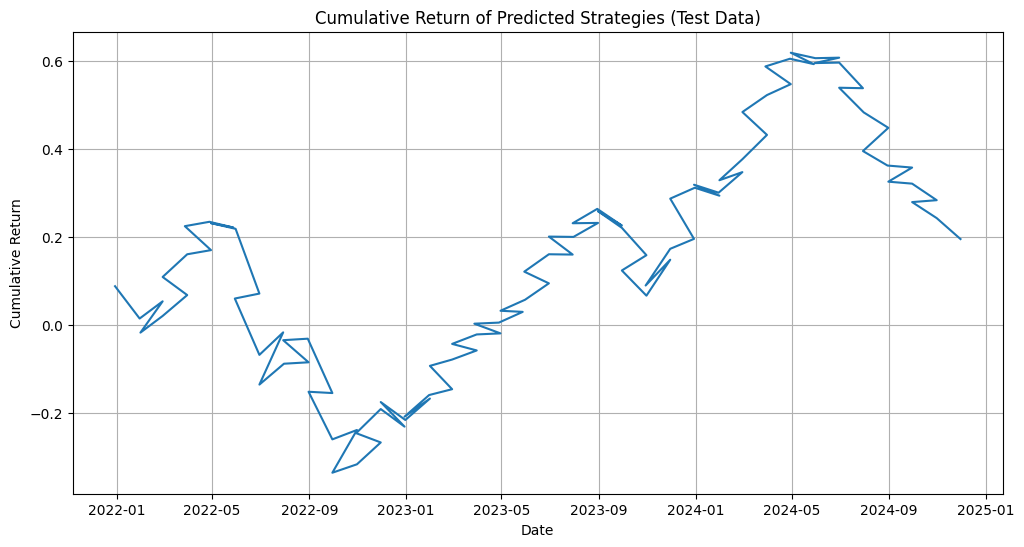

In [139]:
import matplotlib.pyplot as plt

# Generate predictions on test data
model.eval()
all_preds = []
with torch.no_grad():
    for X_batch, _, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)  # (batch_size, prediction_horizon, num_strategies)
        
        # Get predicted strategies
        _, predicted = torch.max(outputs, 2)  # (batch_size, prediction_horizon)
        all_preds.append(predicted.cpu().numpy())

# Concatenate predictions
all_preds = np.concatenate(all_preds, axis=0)  # (num_samples, prediction_horizon)

# Flatten predictions and dates
predicted_strategies = all_preds.flatten()  # (total_predictions,)
test_returns_flat = y_returns_test.reshape(-1, num_strategies)  # (total_predictions, num_strategies)
prediction_dates = []

# Generate dates for each prediction
test_dates = dates[test_indices]
for date in test_dates:
    for i in range(prediction_horizon):
        prediction_dates.append(date + pd.DateOffset(months=i+1))
prediction_dates = pd.to_datetime(prediction_dates)

# Ensure lengths match
prediction_dates = prediction_dates[:len(predicted_strategies)]

# Get returns of predicted strategies
selected_returns = []
for i in range(len(predicted_strategies)):
    strategy_idx = predicted_strategies[i]
    strategy_return = test_returns_flat[i, strategy_idx]
    selected_returns.append(strategy_return)

# Calculate cumulative returns
selected_returns = np.array(selected_returns)
cumulative_returns = np.cumprod(1 + selected_returns) - 1

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(prediction_dates, cumulative_returns)
plt.title('Cumulative Return of Predicted Strategies (Test Data)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()